In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import matplotlib.colorbar as colorbar
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import sys
import re
from concurrent.futures import ProcessPoolExecutor
import itertools


In [2]:
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
#mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
import psutil

total_ram = psutil.virtual_memory().total
print(f"Total RAM available: {total_ram / (1024 * 1024 * 1024)} GB")
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())


Total RAM available: 70.51294326782227 GB
Number of CPU cores: 32


## General functions

In [4]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

In [5]:
base_dir = "./Data"

databin = 0.001
BinSize = 0.3


In [6]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2].isdigit():
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

In [7]:
len(animal_ids)

30

# Data preprocess with Ephys data (only run this first time)

### Load the csv files for each animal into a dictionary
animal_data = {}
for xlsx_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, xlsx_file)
    animal_data[animal_id] = pd.read_csv(filename)

with open('animal_data.pkl', 'wb') as f:
    pickle.dump(animal_data, f)

In [12]:
with open('animal_data.pkl', 'rb') as f:
    animal_data = pickle.load(f)

In [30]:
# Load the csv file with cross timepoints
behavior_str = "Freezing" # Switch behavior string between "Avoidance", "Escape", "Freezing", "Mesh", "Risk Assessment"
interval_data = pd.read_csv(os.path.join(base_dir,f"allen_data_{behavior_str}.csv"))
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's updated by code.csv"), index_col =0)

In [14]:
photoid

1U1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
Unnamed: 0                                                                  
NaN         SPK01a     SPK02a     SPK08a     SPK09a     SPK12a     SPK24a   
PL GABA          0          0          0          0          0          0   
PL PVT           0          0          0          0          0          0   
PL Nac           0          0          0          0          0          0   

           Unnamed: 7 Unnamed: 8     9L1 Unnamed: 10  ... Unnamed: 404  \
Unnamed: 0                                            ...                
NaN            SPK25a     SPK26a  SPK23a      SPK26a  ...       SPK30a   
PL GABA             0          0       0           0  ...            0   
PL PVT              0          0       0           0  ...            0   
PL Nac              0          0       0           0  ...            1   

               1D6 Unnamed: 406 Unnamed: 407 Unnamed: 408 Unnamed: 409  \
Unnamed: 0                                                               
NaN         SPK02a       SPK03a       SPK06a       SPK13a       SPK14a   
PL GABA          0            0            0            0            0   
PL PVT           0            0            0            0            0   
PL Nac           0            0            0            1            0   

           Unnamed: 410 Unnamed: 411 Unnamed: 412 Unnamed: 413  
Unnamed: 0                                                      
NaN              SPK16a       SPK21a       SPK29a       SPK30a  
PL GABA               0            0            0            0  
PL PVT                0            0            0            0  
PL Nac                1            0            1            1  

[4 rows x 413 columns]

In [15]:
total_columns = 0

for key, df in animal_data.items():
    total_columns += df.shape[1]
total_columns-len(animal_data)

413

In [16]:
photo_animals = [ids for ids in photoid.columns if ids[0].isdigit()]

In [17]:
photo_animals

['1U1',
 '9L1',
 '9F2',
 '1K3',
 '2K3',
 '3K3',
 '4K3',
 '10Z3',
 '2A4',
 '4A4',
 '5A4',
 '6A4',
 '2L4',
 '5M4',
 '1P4',
 '2P4',
 '3P4',
 '4P4',
 '5P4',
 '6P4',
 '1A5',
 '2A5',
 '4A5',
 '5A5',
 '3U5',
 '4U5',
 '5U5',
 '6U5',
 '7U5',
 '1D6']

In [18]:
def unmatched_elements(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    return list(set1.difference(set2)) + list(set2.difference(set1))
unmatched_elements(animal_ids, photo_animals)

[]

In [19]:
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [20]:
PhotoTag = pd.DataFrame(columns=['Animal_ID', 'Unit_id', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [21]:
PhotoTag

Animal_ID Unit_id     Unit_Type
0         1U1  SPK01a  Unidentified
1         1U1  SPK02a  Unidentified
2         1U1  SPK08a  Unidentified
3         1U1  SPK09a  Unidentified
4         1U1  SPK12a  Unidentified
..        ...     ...           ...
408       1D6  SPK14a  Unidentified
409       1D6  SPK16a        PL-NAc
410       1D6  SPK21a  Unidentified
411       1D6  SPK29a        PL-NAc
412       1D6  SPK30a        PL-NAc

[413 rows x 3 columns]

In [22]:
# PhotoTag.loc[PhotoTag.Unit_Type == 'PL GABA', 'Unit_Type'] = 'Unidentified'


In [23]:
# Initialize an empty DataFrame to store the results
constructed_all_cells = pd.DataFrame(columns=['Animal_ID', 'Unit_id'])

# Loop through the animal_data_dict dictionary
for animal_id, animal_df in animal_data.items():
    
    # Get the Unit_ids from the column names (2nd to last)
    unit_ids = animal_df.columns[1:]
    
    # Create a new DataFrame with the Animal_ID and Unit_id information
    new_rows = pd.DataFrame({'Animal_ID': [animal_id] * len(unit_ids), 'Unit_id': unit_ids})
    
    # Append the new_rows to the constructed_all_cells DataFrame
    constructed_all_cells = pd.concat([constructed_all_cells, new_rows], ignore_index=True)

# Display the constructed_all_cells DataFrame
print(constructed_all_cells)


    Animal_ID Unit_id
0         3P4  SPK04a
1         3P4  SPK07a
2         3P4  SPK07b
3         3P4  SPK08a
4         3P4  SPK09a
..        ...     ...
408       5A4  SPK28a
409       5A4  SPK30a
410       5U5  SPK20a
411       5U5  SPK28a
412       5U5  SPK28b

[413 rows x 2 columns]


In [24]:
constructed_all_cells

Animal_ID Unit_id
0         3P4  SPK04a
1         3P4  SPK07a
2         3P4  SPK07b
3         3P4  SPK08a
4         3P4  SPK09a
..        ...     ...
408       5A4  SPK28a
409       5A4  SPK30a
410       5U5  SPK20a
411       5U5  SPK28a
412       5U5  SPK28b

[413 rows x 2 columns]

In [25]:
PhotoTag

Animal_ID Unit_id     Unit_Type
0         1U1  SPK01a  Unidentified
1         1U1  SPK02a  Unidentified
2         1U1  SPK08a  Unidentified
3         1U1  SPK09a  Unidentified
4         1U1  SPK12a  Unidentified
..        ...     ...           ...
408       1D6  SPK14a  Unidentified
409       1D6  SPK16a        PL-NAc
410       1D6  SPK21a  Unidentified
411       1D6  SPK29a        PL-NAc
412       1D6  SPK30a        PL-NAc

[413 rows x 3 columns]

In [26]:
np.unique(PhotoTag.Unit_Type, return_counts= True)

(array(['PL GABA', 'PL-NAc', 'PL-PVT', 'Unidentified'], dtype=object),
 array([ 32,  50,  63, 268]))

In [27]:
animal_ids

['3P4',
 '9F2',
 '10Z3',
 '4U5',
 '1U1',
 '5A5',
 '2K3',
 '5P4',
 '1A5',
 '4K3',
 '4P4',
 '4A5',
 '1P4',
 '1D6',
 '6U5',
 '3U5',
 '4A4',
 '2L4',
 '5M4',
 '9L1',
 '2P4',
 '1K3',
 '3K3',
 '2A5',
 '6A4',
 '6P4',
 '2A4',
 '7U5',
 '5A4',
 '5U5']

In [28]:

merged_df = PhotoTag.merge(constructed_all_cells, on=['Animal_ID', 'Unit_id'], how='outer', indicator=True)
non_matching_rows = merged_df[merged_df['_merge'] != 'both']
non_matching_rows

Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []

In [29]:
# Merge the DataFrames on 'Animal_ID' and 'Unit_id'
merged_df = PhotoTag.merge(constructed_all_cells, on=['Animal_ID', 'Unit_id'], how='outer', indicator=True)

# Find the duplicate matches
duplicate_matches = merged_df[merged_df.duplicated(['Animal_ID', 'Unit_id'], keep=False)]

# Find the missing matches
missing_matches_left = merged_df[merged_df['_merge'] == 'left_only']
missing_matches_right = merged_df[merged_df['_merge'] == 'right_only']

# Display the results
print("Duplicate matches:")
print(duplicate_matches)

print("\nMissing matches in PhotoTag:")
print(missing_matches_left)

print("\nMissing matches in all_cells:")
print(missing_matches_right)



Duplicate matches:
Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []

Missing matches in PhotoTag:
Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []

Missing matches in all_cells:
Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []


## Clustering set up

Some work is required before applying the following code to set up the data for clustering. In general, all Scikitlearn packages take data in a 2D array with samples going along the row axis and features going along the column axis. In my case, this part of the code is written to automatically loop through all the folders of data across all animals and the days of interest to pool data from all neurons recorded under a given condition. I am not including this code here since it is quite specific to my data organization. This data is assumed below to be contained in the `populationdata` variable.

I do all of the clustering on the fluorescence itself, instead of deconvolved fluorescence. This is because we found that there is significant bias in deconvolution, at least in detecting inhibition of fluorescence. For each neuron, I transformed its fluorescence into a normalized fluorescence based on the following equation

$$NF(t)=\frac{F(t)-F_{median}(t)}{F_{max}(t)-F_{min}(t)}$$

This makes the median fluorescence value be zero. For a real neuron with large calcium events, the median fluorescence will be close to baseline. Hence, baseline will be close to zero and all large calcium events will be positive numbers less than 1. The reason for such scaling is to ensure that the fluorescence across all neurons is directly comparable and plottable in a single scale. This is used purely for visualization and not for any analysis.

In my case, I define the "response features" of a neuron as the peristimulus time histogram of its normalized fluorescence (defined above) between -3 s before cues to +17 s after cue (reward is delivered 3 s after CS+). While this is a long time period, I found that there are a few neurons that show clear sustained activity difference much after the reward, into the intertrial interval. I effectively sample my fluorescence imaging at 5 Hz. So in effect, there are 20 s * 5 Hz = 100 features for each cue type. Since CS+ and CS- responses are both "response features", for any given neuron, I concatenate these 100 features side by side to obtain 200 features in total. I recorded 4813 neurons in total. So the data array is 4813 x 200 in size.

Since 200 dimensions in the feature space is actually quite large, I first reduce the dimensionality of this space by doing PCA along this axis. I then retain only the first few PCs that correspond to the dimensions explaining the most variability. I just use a simple scree plot approach for this. There are fancier ways to do this, but I found that those ways generally produced less reproducible results across animals. So I favored retaining the minimal number of relevant PCs.

**Below, the variable `populationdata` corresponds to the 4813 x 200 array, which pools all normalized PSTH fluorescence data across all neurons. We will first load this variable from the corresponding numpy file**

## 6s before and after and normalized to 6s before

In [216]:
reward_data = pd.read_csv(os.path.join(basedir, f'{behavior_str}_PL_nex_file_updated_by_code_6s.csv'))
reward_data.columns = ["Animal_ID", "Unit_id"] + list(reward_data.columns[2:])
reward_data

Animal_ID Unit_id         0         1         2         3         4  \
0         1U1  SPK01a -0.719492 -1.615908 -0.436413  0.365643  0.695902   
1         1U1  SPK02a  0.837318  0.005938 -0.944209 -2.013125 -0.112830   
2         1U1  SPK08a  0.076476  1.253032  0.311787  0.429443 -0.394146   
3         1U1  SPK09a -0.567224 -0.043633 -1.614408  0.305429 -0.392694   
4         1U1  SPK12a  0.160214  0.160214 -0.068663 -1.213051  0.846847   
..        ...     ...       ...       ...       ...       ...       ...   
408       4U5  SPK27a  1.268415  0.504821  1.225993  0.123024  0.844196   
409       4U5  SPK28a  0.420952 -1.390740 -0.857889 -0.111899  0.527522   
410       4U5  SPK29a  1.047298 -0.005541  0.881061 -0.227192 -0.116366   
411       4U5  SPK31a  0.985606 -0.071749  0.079302  1.665334  0.910080   
412       4U5  SPK31b  0.248874 -0.995495  0.782175 -0.165916  0.367385   

            5         6         7  ...        31        32        33  \
0   -0.389233  1.356419 -0.389233  ... -1.615908 -0.766672 -0.389233   
1    0.124707  0.837318 -1.062978  ...  0.124707 -0.587904  0.005938   
2    1.135377  2.547244 -1.335391  ...  0.782410 -0.629458  0.076476   
3   -0.043633 -0.741755 -0.567224  ... -1.963469 -0.567224 -0.218163   
4    1.304602  1.190163  0.160214  ...  0.160214  0.961285 -0.984173   
..        ...       ...       ...  ...       ...       ...       ...   
408  0.123024 -0.046664  0.716930  ... -1.743540 -1.998071 -1.446587   
409 -0.325039  0.420952  2.019503  ...  1.273513 -0.964459  0.847232   
410 -0.338017 -1.002968 -1.224619  ... -2.166633  0.160697 -1.612507   
411  0.079302  0.003776  1.363233  ... -1.959883 -2.261984 -2.186459   
412  0.485897  1.730266 -0.047405  ... -0.580706 -1.825075 -0.936240   

           34        35        36        37        38        39        40  
0    0.224104  0.695902 -1.191290 -0.577952  0.648722 -1.380009  0.224104  
1    0.005938  3.568992  4.281602  0.124707  4.281602 -0.587904  4.044065  
2   -1.335391  0.194132 -0.276491 -1.100080  0.900066 -0.276491  0.194132  
3   -1.090816 -0.392694  0.654490 -0.218163 -0.741755  1.178081  2.050734  
4   -1.213051  0.160214  0.846847  0.160214 -0.869734  0.617969 -1.785244  
..        ...       ...       ...       ...       ...       ...       ...  
408 -1.489009 -1.743540 -1.743540 -2.125337 -1.658696 -1.785962 -1.531430  
409 -1.497310  0.101242  0.847232  1.273513  0.420952  1.593223  1.486653  
410 -2.609934 -3.441124 -3.330298 -1.557095 -1.723332 -2.443696 -2.388284  
411 -1.506731 -1.355680 -1.204629 -1.884357 -2.186459 -1.280155 -1.129104  
412 -0.758473 -1.469541 -0.462194 -1.054751 -0.817728 -0.639961 -0.580706  

[413 rows x 43 columns]

In [44]:
# basedir = './Data' # folder containing code and data
# first_row = pd.read_csv(os.path.join(basedir, f'{behavior_str}_PL_nex_file_updated_by_code_6s.csv'), nrows=1, index_col=0)
# column_names = first_row.columns
# data = pd.read_csv(os.path.join(basedir, f'{behavior_str}_PL_nex_file_updated_by_code_6s.csv'), index_col=0, dtype=float, skiprows=2, header = None)
# data.columns = column_names
# Reward_6s_z_6s = pd.concat([first_row, data], axis=0)

# first_row = pd.read_csv(os.path.join(basedir, 'Conflict_tone_responses_PL_nex_output.csv'), nrows=1, index_col=0)
# column_names = first_row.columns
# data = pd.read_csv(os.path.join(basedir, 'Conflict_tone_responses_PL_nex_output.csv'), index_col=0, dtype=float, skiprows=2, header = None)
# data.columns = column_names
# Conflict_6s_z_6s = pd.concat([first_row, data], axis=0)

In [28]:
# Reward_6s_z_6s = Reward_6s_z_6s.reset_index(drop=True)
# Conflict_6s_z_6s =  Conflict_6s_z_6s.reset_index(drop=True)

In [46]:
# reward_ids = pd.DataFrame(columns=['Animal_ID', 'Unit_id'])


# # Iterate over the columns in the input DataFrame
# current_animal_id = None
# for i, col in enumerate(Reward_6s_z_6s.columns):
#     if 'Unnamed' not in col:
#         current_animal_id = col
#     unit_id = Reward_6s_z_6s.iloc[0, i]
#     new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id]})
#     reward_ids = pd.concat([reward_ids, new_row], ignore_index=True)

# reward_data = pd.concat([reward_ids,Reward_6s_z_6s.iloc[1:-1,:].T.reset_index(drop=True)],axis = 1)
# reward_data

In [47]:
# conflict_ids = pd.DataFrame(columns=['Animal_ID', 'Unit_id'])


# # Iterate over the columns in the input DataFrame
# current_animal_id = None
# for i, col in enumerate(Reward_6s_z_6s.columns):
#     if 'Unnamed' not in col:
#         current_animal_id = col
#     unit_id = Reward_6s_z_6s.iloc[0, i]
#     new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id]})
#     conflict_ids = pd.concat([conflict_ids, new_row], ignore_index=True)

# conflict_data = pd.concat([conflict_ids,Conflict_6s_z_6s.iloc[1:-1,:].T.reset_index(drop=True)],axis = 1)
# conflict_data

In [31]:
conflict_ids.equals(reward_ids)

True

In [76]:

reward = reward_data.iloc[:,2:-1].to_numpy(dtype = float)
# conflict = conflict_data.iloc[:,2:].to_numpy(dtype = float)

TimeRange = 12
TotalBins = reward.shape[1]

populationdata = np.concatenate([reward],axis =1)
reward_data = reward_data[~np.any(np.isnan(populationdata), axis=1)]
PhotoTag = PhotoTag[~np.any(np.isnan(populationdata), axis=1)]
populationdata = populationdata[~np.any(np.isnan(populationdata), axis=1)]

<Axes: >

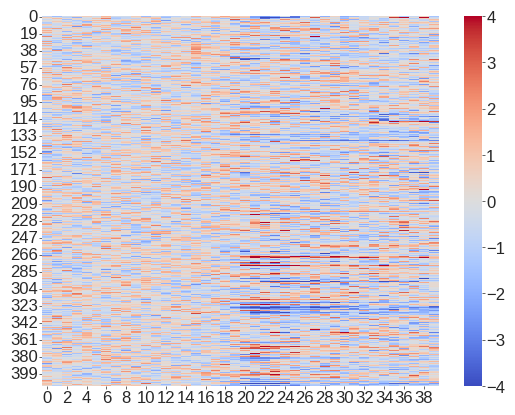

In [77]:
cmax = 4 # Maximum colormap value. 
cmin = -4
sns.heatmap(reward,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax)

In [78]:
populationdata.flatten().max()

7.898274246595732

(array([6.000e+00, 4.400e+01, 5.170e+02, 4.267e+03, 8.023e+03, 3.256e+03,
        3.590e+02, 4.000e+01, 4.000e+00, 4.000e+00]),
 array([-6.38119794, -4.95325072, -3.5253035 , -2.09735629, -0.66940907,
         0.75853815,  2.18648537,  3.61443259,  5.04237981,  6.47032703,
         7.89827425]),
 <BarContainer object of 10 artists>)

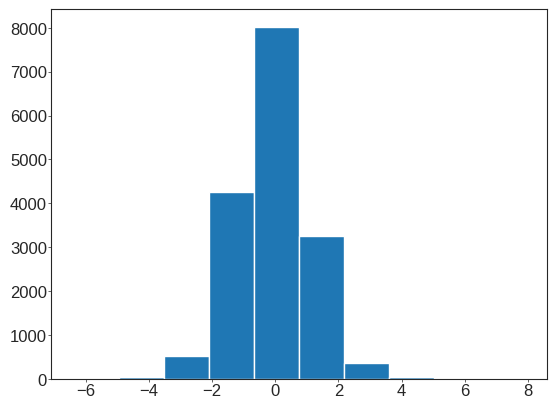

In [79]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [80]:
populationdata.shape

(413, 40)

In [81]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 6 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 6 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + int(1*framerate)] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 
cmin = -4

trial_types = ['Cat Odor']

/tmp/ipykernel_3562044/4245763467.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


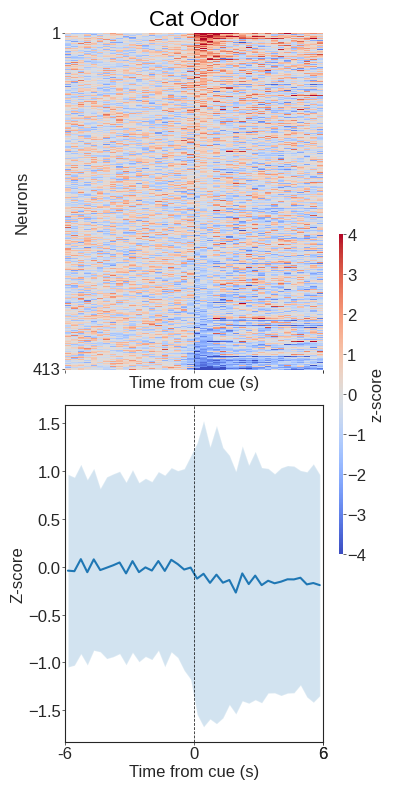

In [82]:
fig, axs = plt.subplots(2, 1,figsize=(2*2,4*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0].set_title(trial_types[t])
    ax = axs[0]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([0, len(sortresponse)-1])
    ax.set_yticklabels(['1', str(len(sortresponse))])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int(round((a - pre_window_size) / framerate))) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0].set_ylabel('Neurons')
axs[1].set_ylabel('Z-score')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 11
Number of PCs to keep = 7


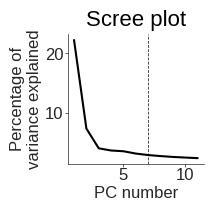

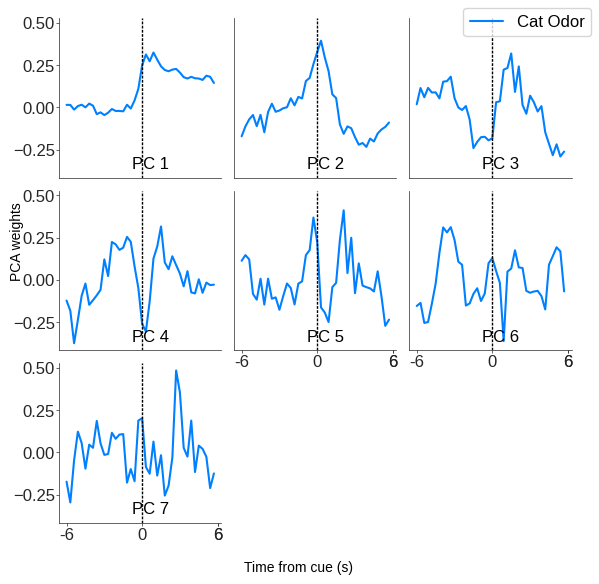

In [192]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=0.55, whiten=True) #    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, f'{behavior_str}_pcaresults_photoid_updated.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.min(np.where(np.cumsum(x)>50))-1 #len(pca.components_)#np.min(np.where(np.cumsum(x)>55)) #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
# colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int(round((a - pre_window_size) / framerate)))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [194]:
sum(x[:7])

46.90285607406917

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [195]:
max_n_clusters = 9 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(3, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).

possible_n_nearest_neighbors = np.array([15, 25, 35, 40, 45, 50, 55, 60, 65, 70, 80, 85, 90, 95, 100, 120, 140, 200]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset

# possible_n_nearest_neighbors = np.array([5, 10, 50, 80,100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'Freezing_silhouette_scores_photoid_updated.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 3, num nearest neighbors = 15: score = 0.180
Done with numclusters = 3, num nearest neighbors = 25: score = 0.165
Done with numclusters = 3, num nearest neighbors = 35: score = 0.166
Done with numclusters = 3, num nearest neighbors = 40: score = 0.169
Done with numclusters = 3, num nearest neighbors = 45: score = 0.178
Done with numclusters = 3, num nearest neighbors = 50: score = 0.182
Done with numclusters = 3, num nearest neighbors = 55: score = 0.186
Done with numclusters = 3, num nearest neighbors = 60: score = 0.187
Done with numclusters = 3, num nearest neighbors = 65: score = 0.186
Done with numclusters = 3, num nearest neighbors = 70: score = 0.186
Done with numclusters = 3, num nearest neighbors = 80: score = 0.189
Done with numclusters = 3, num nearest neighbors = 85: score = 0.188
Done with numclusters = 3, num nearest neighbors = 90: score = 0.188
Done with numclusters = 3, num nearest neighbors = 95: score = 0.187
Done with numclusters = 3, num nea

Done with numclusters = 9, num nearest neighbors = 90: score = 0.218
Done with numclusters = 9, num nearest neighbors = 95: score = 0.211
Done with numclusters = 9, num nearest neighbors = 100: score = 0.210
Done with numclusters = 9, num nearest neighbors = 120: score = 0.202
Done with numclusters = 9, num nearest neighbors = 140: score = 0.186
Done with numclusters = 9, num nearest neighbors = 200: score = 0.168
Done with model fitting


Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [196]:
with open(os.path.join(basedir, 'Freezing_silhouette_scores_photoid_updated.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
# silhouette_scores = temp

transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][-1]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][-1]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])-np.mean(populationdata[rawlabels==label, 0:pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

def desaturate_color(rgb_color, saturation_factor):
    # Convert RGB to HSV
    hsv_color = rgb_to_hsv(rgb_color[:3])  # Exclude the alpha value if present
    # Reduce the saturation component
    hsv_color[1] *= saturation_factor
    # Convert back to RGB and return with original alpha if it was included
    return hsv_to_rgb(hsv_color)


colors_for_cluster = [desaturate_color(cm.get_cmap("tab20")(i / 20.0), 0.7) for i in range(0,20)]


8 55
Number of clusters = 8, average silhouette = 0.221


/tmp/ipykernel_3562044/234122640.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_for_cluster = [desaturate_color(cm.get_cmap("tab20")(i / 20.0), 0.7) for i in range(0,20)]


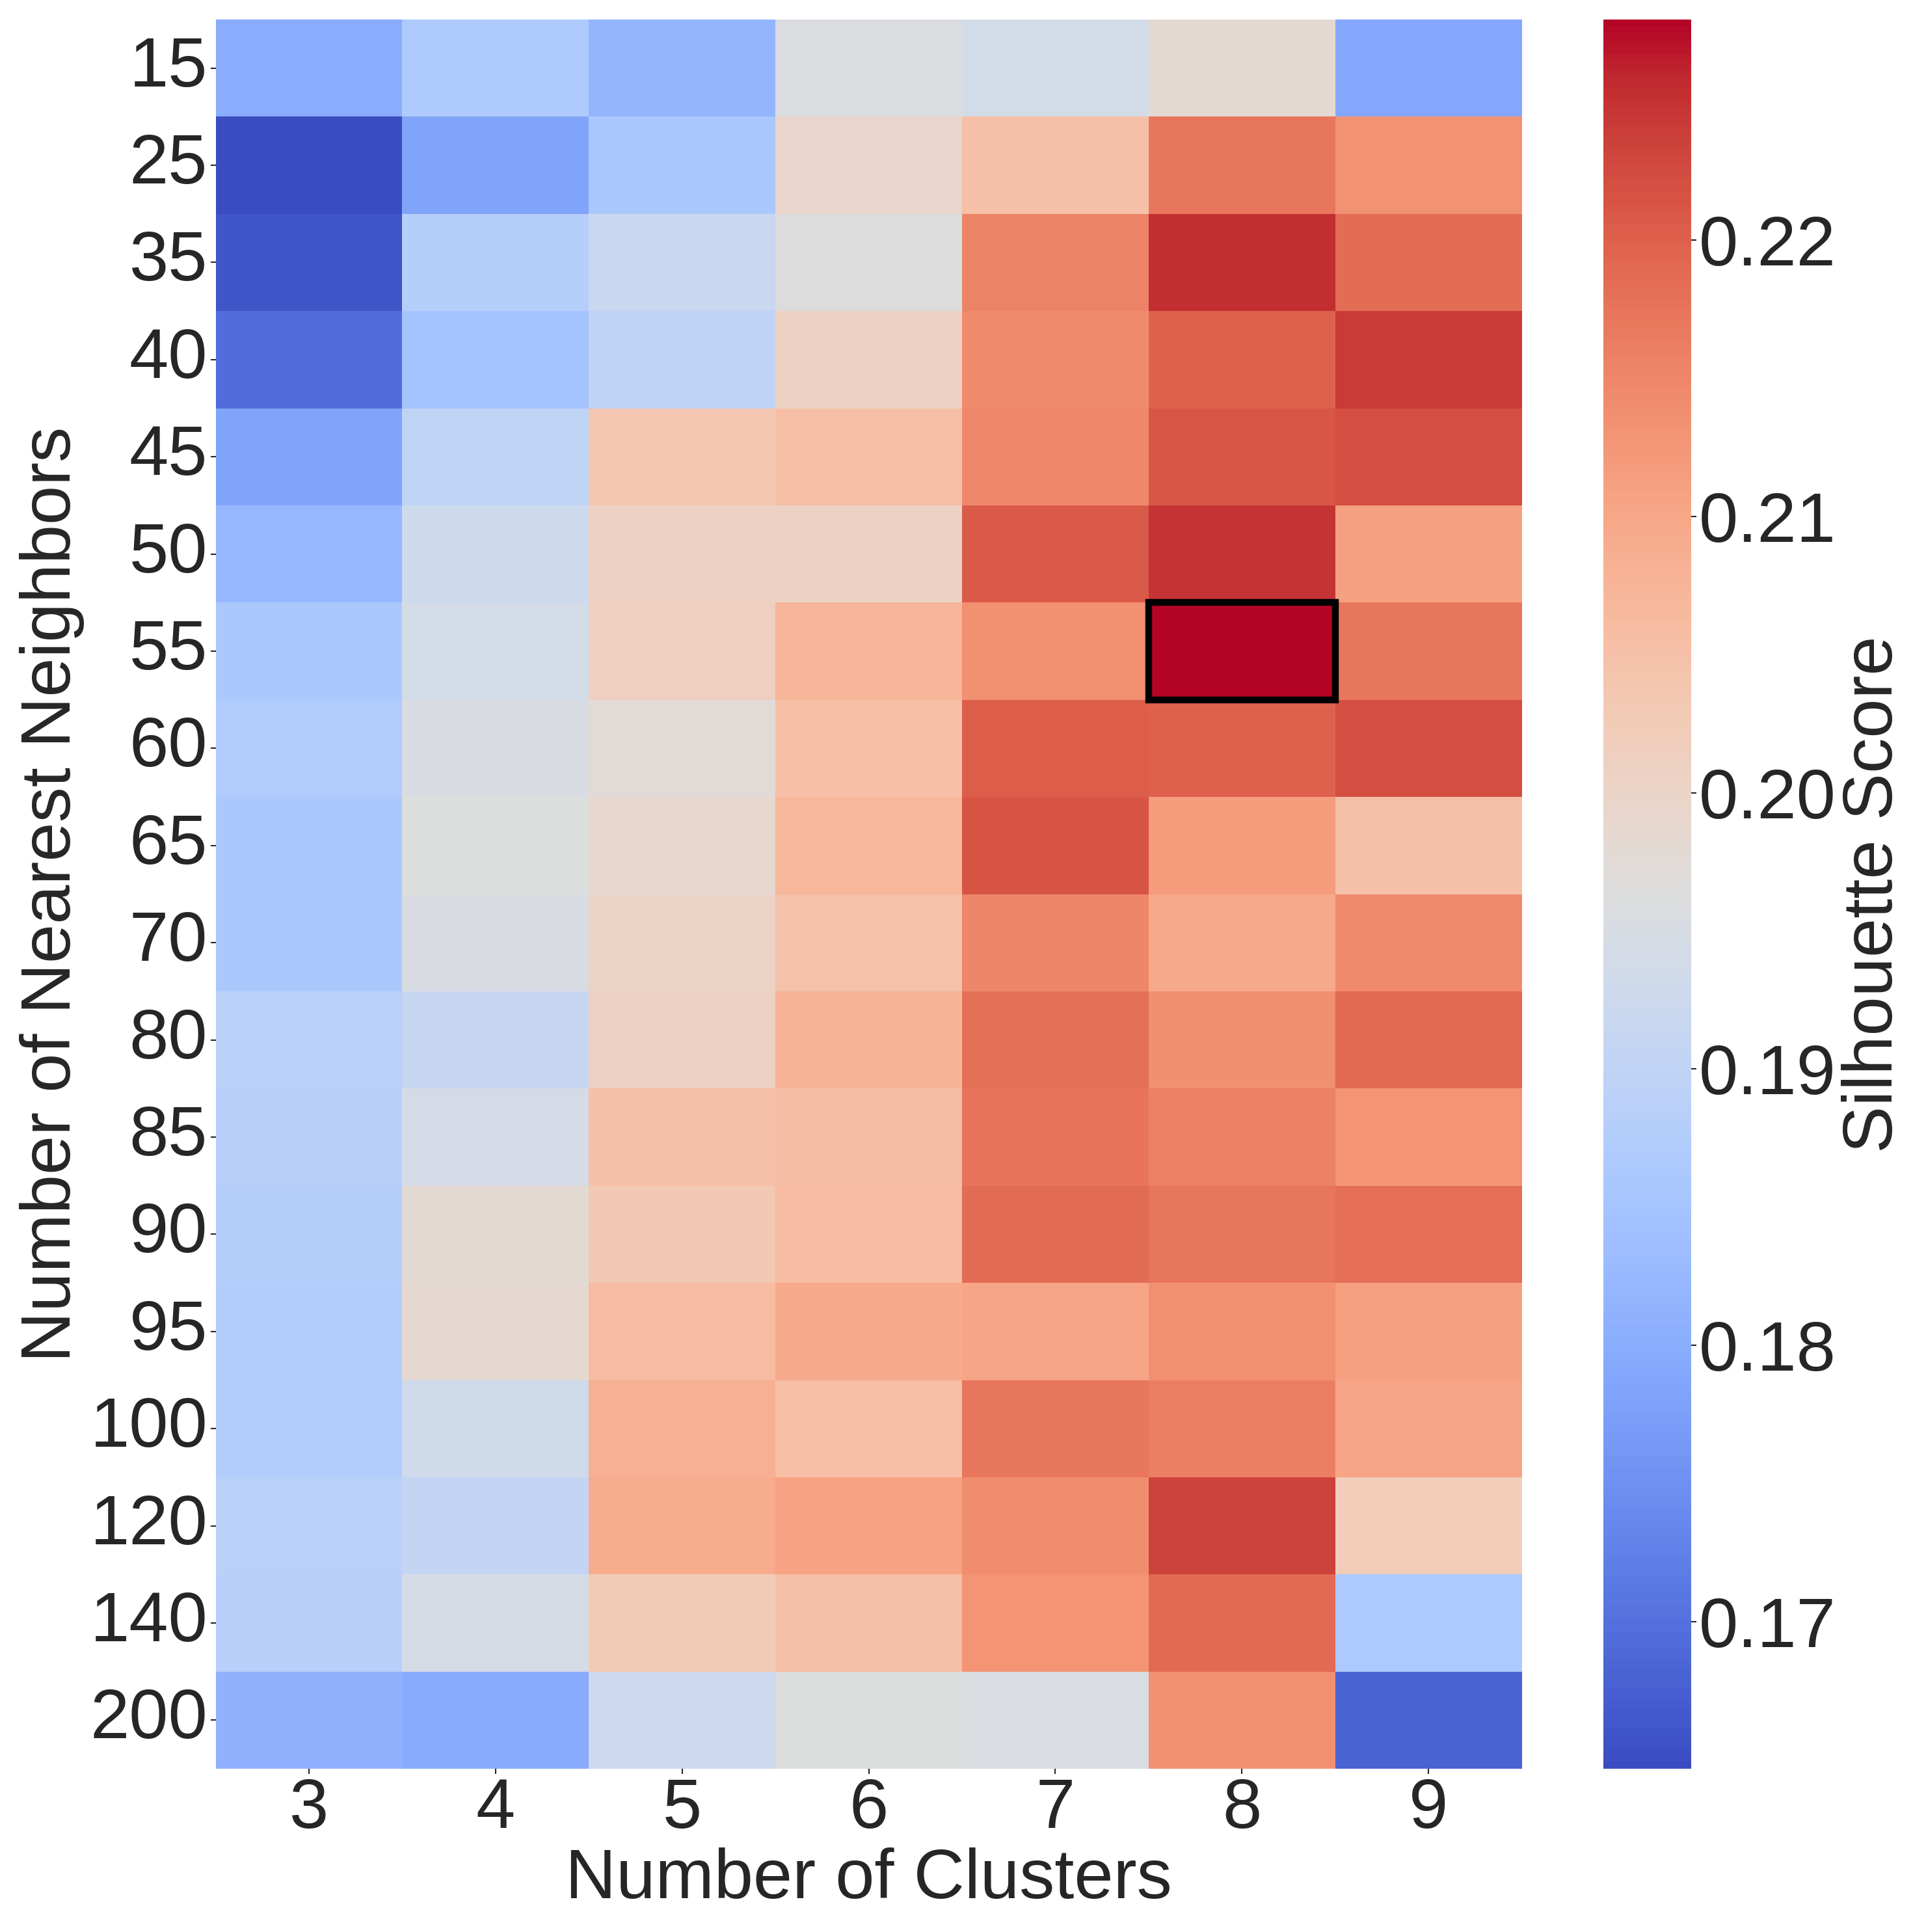

In [197]:
max_n_clusters = 9
possible_n_clusters = np.arange(3, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).

possible_n_nearest_neighbors = np.array([15, 25, 35, 40, 45, 50, 55, 60, 65, 70, 80, 85, 90, 95, 100, 120, 140, 200]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset

n_clusters_idx = np.where(possible_n_clusters == n_clusters)[0][0]  
n_nearest_neighbors_idx = np.where(possible_n_nearest_neighbors == n_nearest_neighbors)[0][0] 

fig, ax = plt.subplots(figsize = (10, 10), dpi =300)
sns_heatmap = sns.heatmap(silhouette_scores['silhouette_scores'].T, cmap = 'coolwarm', 
                    cbar_kws={'label': 'Silhouette Score'}, ax = ax)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Silhouette Score', fontsize=26)
cbar.ax.tick_params(labelsize=26)  # This sets the tick label size
ax.set_yticklabels(possible_n_nearest_neighbors, rotation = 0, fontsize = 26)
ax.set_xticklabels(possible_n_clusters, fontsize = 26)
ax.set_xlabel('Number of Clusters', fontsize = 26)
ax.set_ylabel('Number of Nearest Neighbors', fontsize = 26)

rectangle = patches.Rectangle((n_clusters_idx, n_nearest_neighbors_idx), 1, 1, linewidth=2.5, edgecolor='black', facecolor='none', transform=ax.transData)
ax.add_patch(rectangle)


plt.tight_layout()
# plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_cluster_safe_vs_threat_num_silhouette.svg", transparent=True)


plt.show()

Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [198]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1, dpi = 300)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1), fontsize = 12)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters", fontsize = 16)
    ax.set_xlabel("The silhouette coefficient values",  fontsize = 16)
    ax.set_ylabel("Cluster label",  fontsize = 16)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticklabels([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 16)

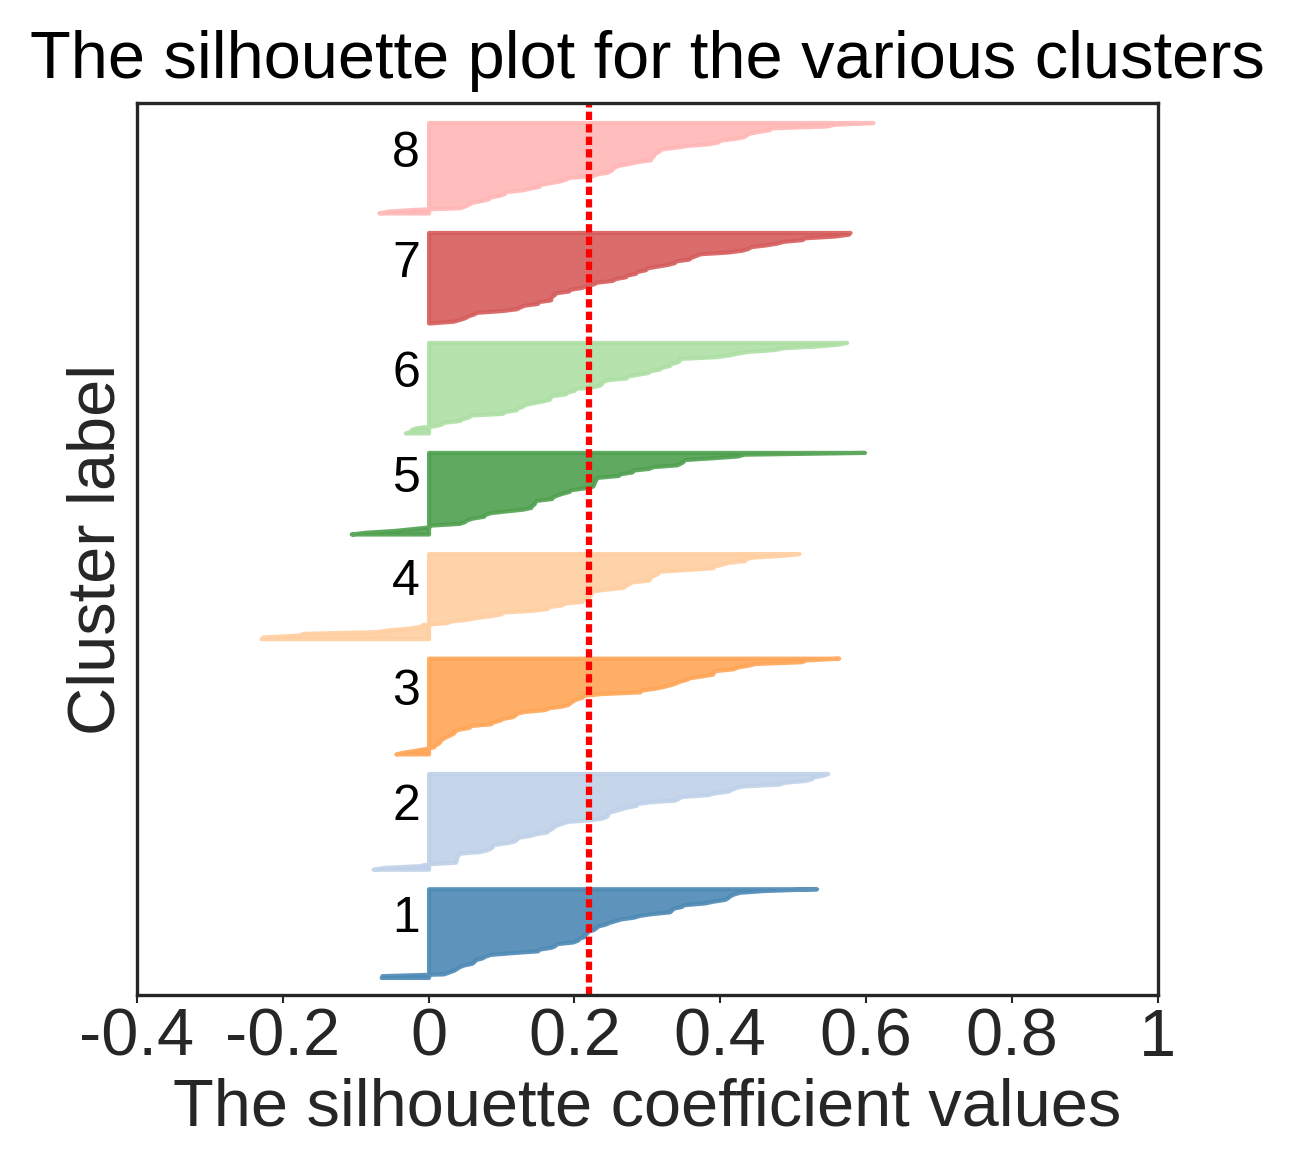

In [199]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)
plt.tight_layout()
# plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_cluster_safe_vs_threat_silhouette.svg", transparent=True)


The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [200]:
np.savetxt("populationdata_catodor_photoid_updated_freezing.csv", populationdata, delimiter=",")
np.savetxt("newlabels_catodo_photoid_updated_freezing.csv", newlabels, delimiter=",")

In [201]:
populationdata = pd.read_csv("populationdata_catodor_photoid_updated_freezing.csv", header = None).to_numpy()
newlabels = pd.read_csv("newlabels_catodo_photoid_updated_freezing.csv", header = None).to_numpy(dtype = int)
uniquelabels = np.unique(newlabels)


In [202]:
populationdata

array([[-0.71949172, -1.61590763, -0.43641301, ..., -0.57795237,
         0.64872204, -1.38000871],
       [ 0.83731752,  0.00593842, -0.94420912, ...,  0.12470687,
         4.28160237, -0.58790379],
       [ 0.07647616,  1.25303246,  0.31178742, ..., -1.10008014,
         0.90006557, -0.27649073],
       ...,
       [ 1.04729847, -0.00554126,  0.88106062, ..., -1.55709456,
        -1.72333241, -2.44369644],
       [ 0.98560581, -0.07174908,  0.07930162, ..., -1.88435747,
        -2.18645887, -1.28015467],
       [ 0.24887387, -0.99549547,  0.78217501, ..., -1.05475116,
        -0.81772842, -0.63996138]])

/tmp/ipykernel_3562044/2674691416.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


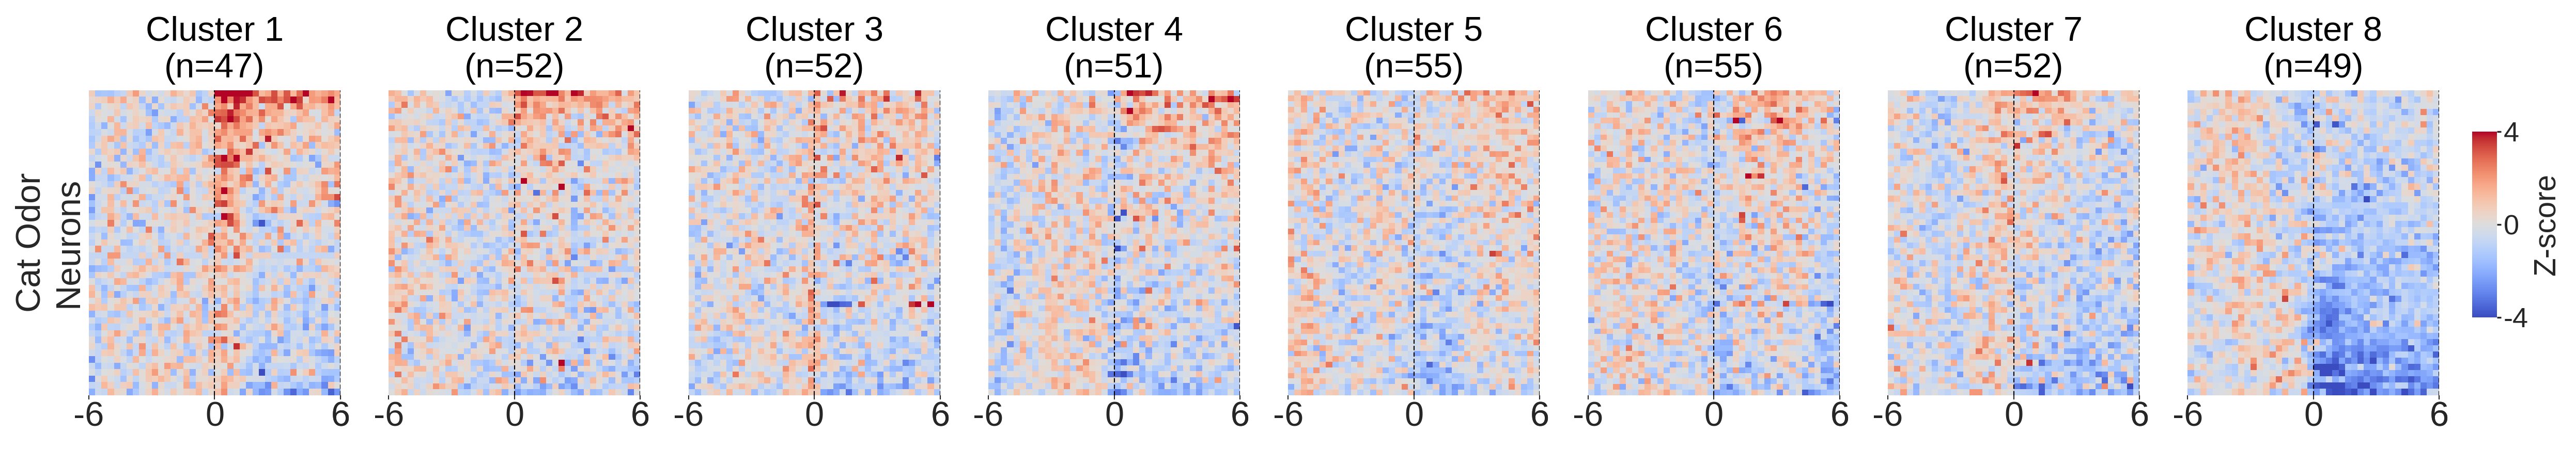

In [244]:
cmax = 4
cmin = -4
#sortwindow = [15, 100]
sortwindow = [pre_window_size+1, window_size]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(trial_types)), dpi = 300)
cbar_ax = fig.add_axes([1, .3, .01, .4])
cbar_ax.tick_params(width=0.8) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=cmin,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Z-score'},
                    rasterized=True)
        axs[cluster].grid(False)
        if k==len(trial_types)-1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
            axs[cluster].set_xticklabels([str(int(round((a-pre_window_size+0.0)/framerate)))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        else:
            axs[cluster].set_xticks([])
        axs[cluster].tick_params(width=0.5, labelsize=16)
        axs[cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        
        axs[cluster].set_yticks([])
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[0].set_ylabel('%s\nNeurons'%(tempkey), fontsize = 16)
    axs[cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]), fontsize = 16)

    if cluster == 0:  # Adjustments are only needed for the first cluster where the colorbar is created
        # Set colorbar label size (if needed to adjust)
        cbar_ax.set_ylabel('Z-score', fontsize=14)  # Adjust font size as needed
        cbar_ticks = [cmin, (cmin+cmax)/2, cmax]
        # Update the colorbar ticks
        cbar_ax.set_yticks(cbar_ticks)
        # Optionally, update the tick labels, for example, showing the limits and the midpoint
        cbar_ax.set_yticklabels([str(cmin), f'{(cmin+cmax)/2:.0f}', str(cmax)])
        # Set colorbar tick label size
        cbar_ax.tick_params(labelsize=13)  # Adjust the tick label font size as needed

    
# fig.text(0.5, 0.05, 'Time from cue onset (s)', fontsize=16,
#          horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.tight_layout()
plt.savefig(f"/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_{behavior_str}_cluster_safe_vs_threat_heatmap.svg", transparent=True, bbox_inches='tight')

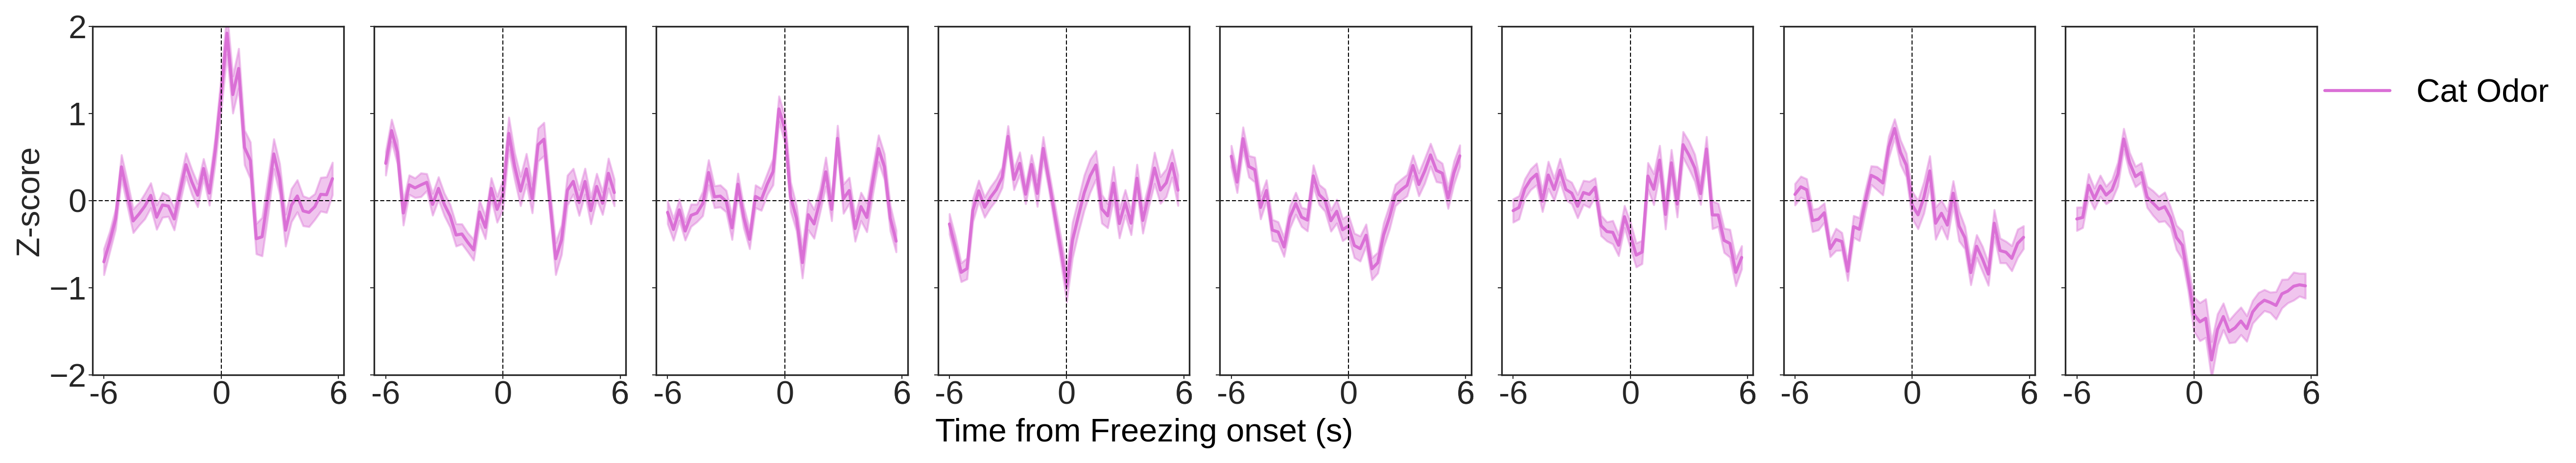

In [247]:
fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 3 * len(trial_types)),dpi =300)

numroisincluster = np.nan * np.ones((len(uniquelabels),))
colors = ['orchid', 'olivedrab']
trials = trial_types
lines = []

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Store the Line2D instances for creating the legend later
        line, = axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        lines.append(line)

        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color=colors[k], alpha=0.4)

        #axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int(round((a - pre_window_size) / framerate)))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-2,2)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        #axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster != 0:
            axs[cluster].set_yticklabels([])
        if cluster == 0:
            axs[0].set_ylabel('Z-score', fontsize = 16)
 
#     axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]), fontsize)
    axs[cluster].tick_params(labelsize=16)

# Create the legend at the end, outside of the loop
fig.legend(lines, trials,frameon = False, loc='lower right', bbox_to_anchor=(0.6, 0.67, 0.5, 0.5), fontsize = 16)

fig.text(0.49, 0, f'Time from {behavior_str} onset (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')

# fig.subplots_adjust(wspace=0.15, hspace=0.15)
# fig.subplots_adjust(left=0.03)
# fig.subplots_adjust(right=0.93)
# fig.subplots_adjust(bottom=0.2)
# fig.subplots_adjust(top=0.83)

fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.tight_layout()
plt.savefig(f"/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_{behavior_str}_cluster_safe_vs_threat_line.svg", transparent=True, bbox_inches='tight')

plt.show()


In [248]:
BinSize = TimeRange/TotalBins

In [249]:
0.6/BinSize

2.0

Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

/tmp/ipykernel_3562044/3605203255.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_for_cluster = [desaturate_color(cm.get_cmap("tab20")(i / 20.0), 0.7) for i in range(0,20)]


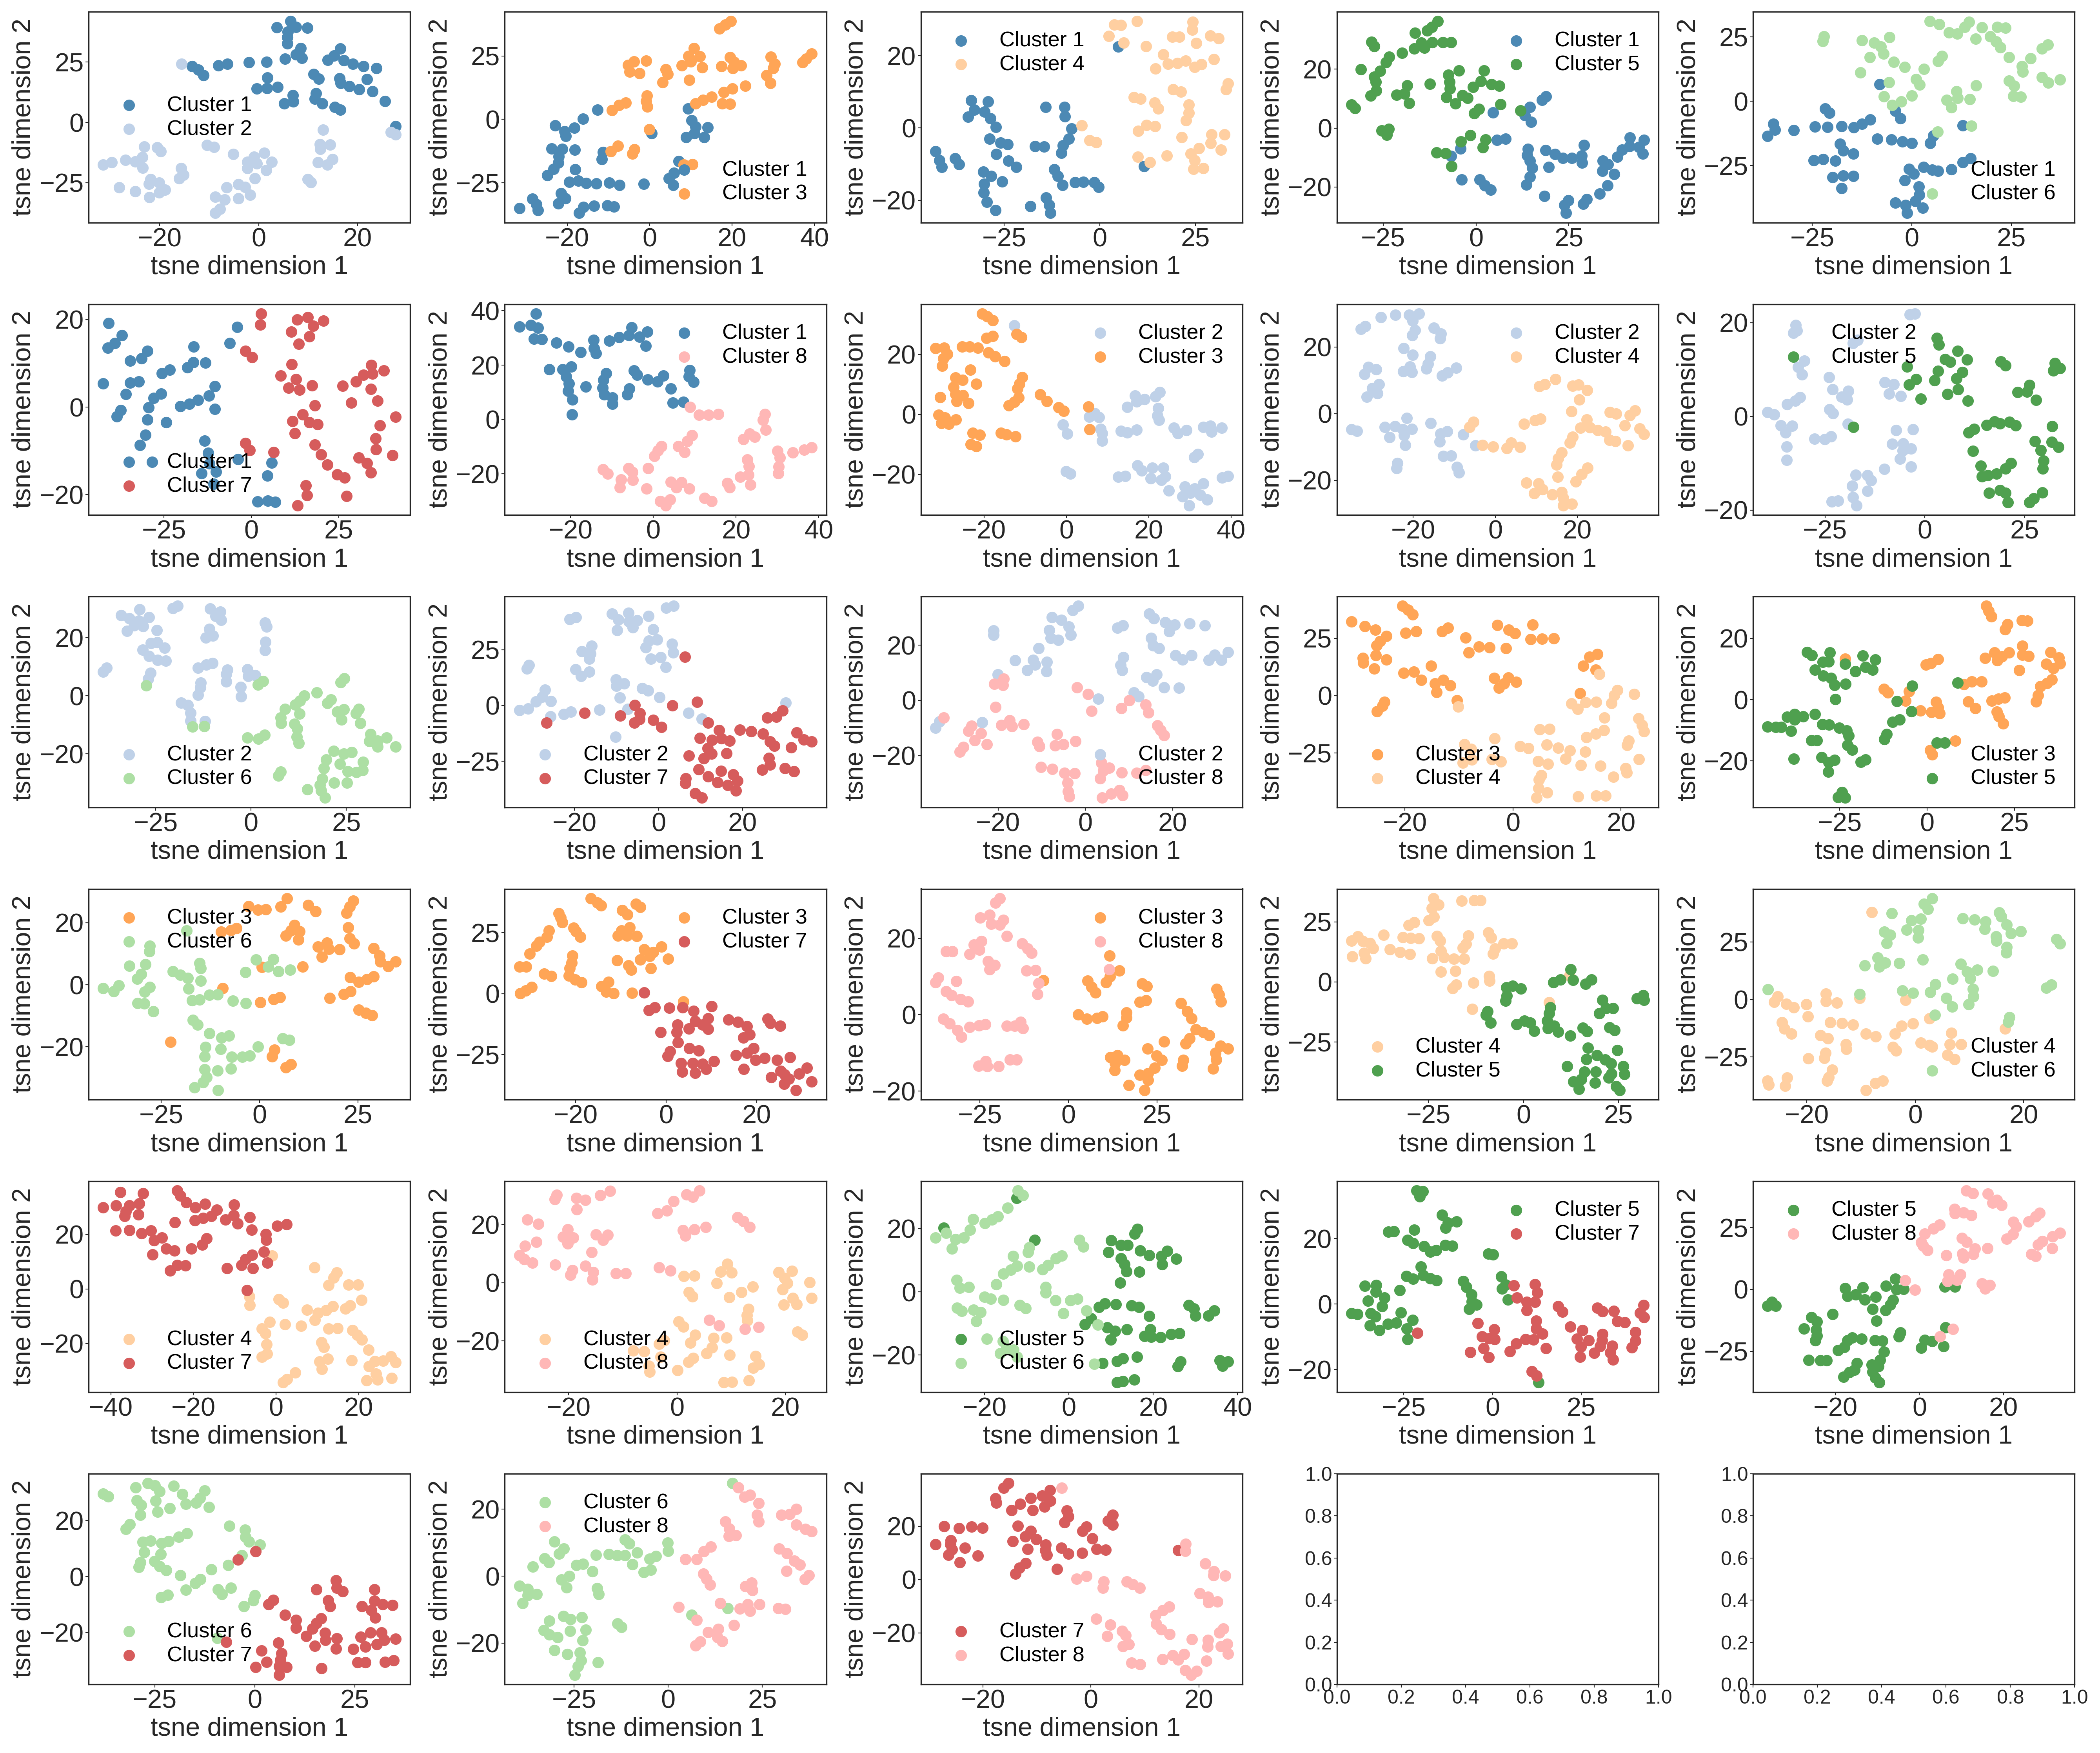

In [250]:
colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

colors_for_cluster = [desaturate_color(cm.get_cmap("tab20")(i / 20.0), 0.7) for i in range(0,20)]
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols), dpi =300)

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[1]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1', fontsize = 16)
        ax.set_ylabel('tsne dimension 2', fontsize = 16)
        ax.tick_params(labelsize = 16)
        ax.legend(fontsize = 13, frameon = False)
        tempsum += 1
fig.tight_layout()

# plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_cluster_safe_vs_threat_tsne.svg", transparent=False, bbox_inches='tight')


In [251]:
all_cells

Animal_ID Unit_id
0         1U1  SPK01a
1         1U1  SPK02a
2         1U1  SPK08a
3         1U1  SPK09a
4         1U1  SPK12a
..        ...     ...
408       4U5  SPK27a
409       4U5  SPK28a
410       4U5  SPK29a
411       4U5  SPK31a
412       4U5  SPK31b

[413 rows x 2 columns]

In [252]:
all_cells = reward_data.iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('Unidentified')
merged['Cluster'] = newlabels+1

merged.to_csv(f"{behavior_str}_Cell_type_cluster_catodor_photoid_updated.csv")
# Check the resulting DataFrame
print(merged)


    Animal_ID Unit_id     Unit_Type  Cluster
0         1U1  SPK01a  Unidentified        3
1         1U1  SPK02a  Unidentified        3
2         1U1  SPK08a  Unidentified        5
3         1U1  SPK09a  Unidentified        1
4         1U1  SPK12a  Unidentified        2
..        ...     ...           ...      ...
408       4U5  SPK27a        PL-PVT        8
409       4U5  SPK28a  Unidentified        3
410       4U5  SPK29a        PL-PVT        8
411       4U5  SPK31a        PL-PVT        8
412       4U5  SPK31b  Unidentified        8

[413 rows x 4 columns]


/tmp/ipykernel_3562044/810460324.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set1')


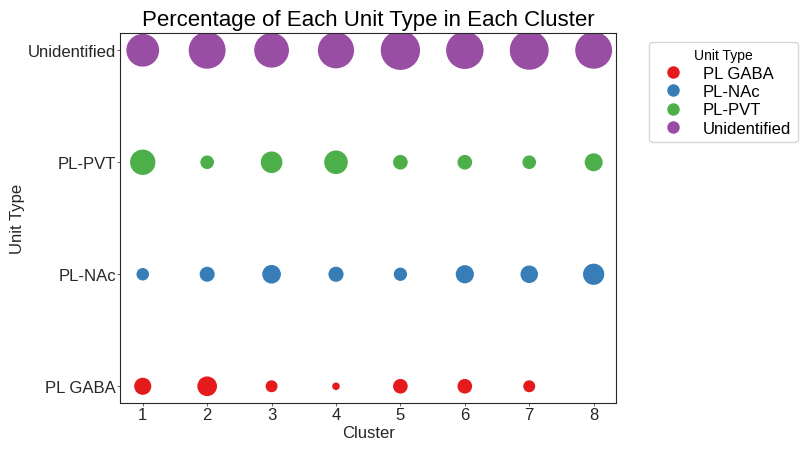

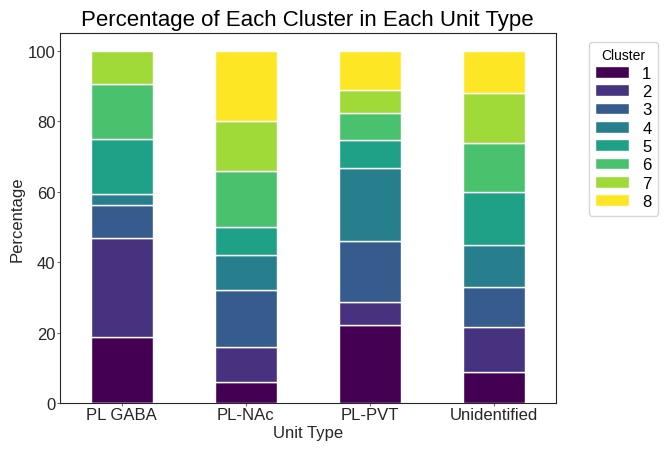

In [219]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)*100

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)*100

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 10, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [220]:
cluster_unit_type_perc

Unit_Type    PL GABA     PL-NAc     PL-PVT  Unidentified
Cluster                                                 
1          12.765957   6.382979  29.787234     51.063830
2          17.307692   9.615385   7.692308     65.384615
3           5.769231  15.384615  21.153846     57.692308
4           1.960784   9.803922  25.490196     62.745098
5           9.090909   7.272727   9.090909     74.545455
6           9.090909  14.545455   9.090909     67.272727
7           5.769231  13.461538   7.692308     73.076923
8           0.000000  20.408163  14.285714     65.306122

/tmp/ipykernel_3562044/3512215221.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')


(-1.0, 3.0)

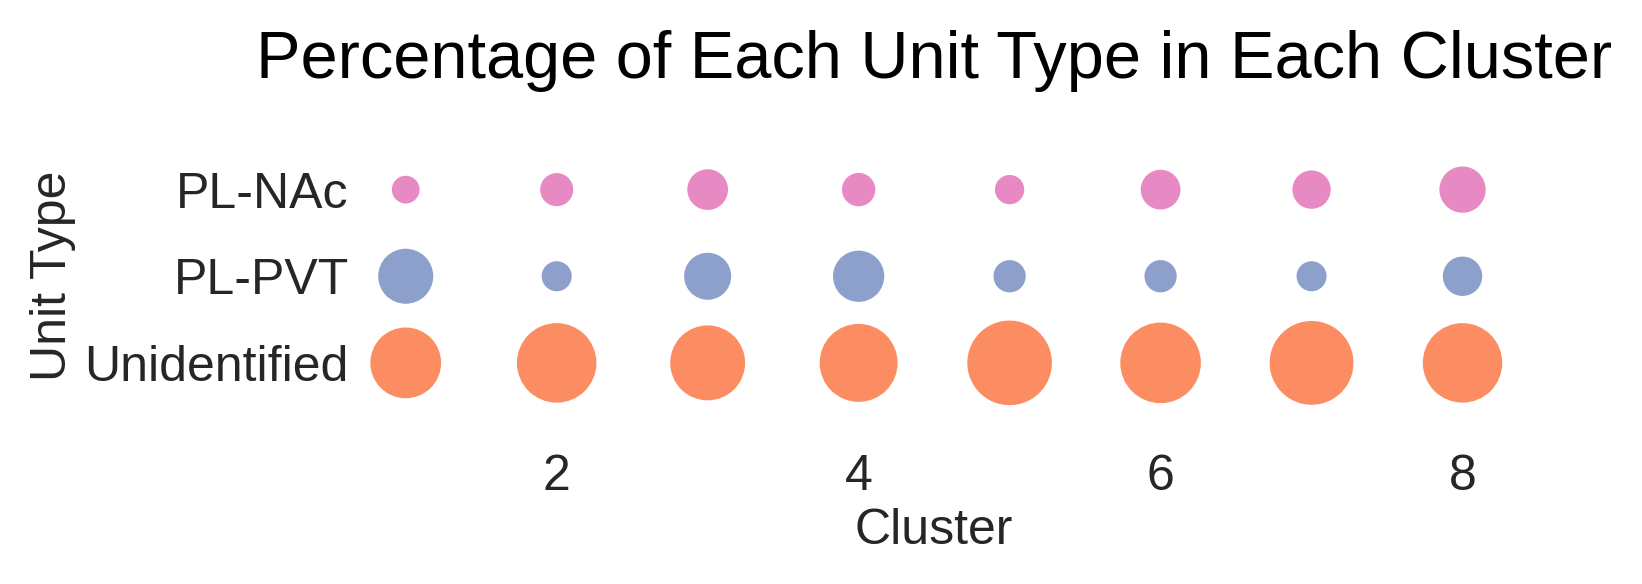

In [221]:
cluster_unit_type_perc_nogaba = cluster_unit_type_perc.iloc[:,cluster_unit_type_perc.columns!='PL GABA']

# Create a dictionary that maps each unit type to a unique numerical value
unit_type_dict = {unit_type: i for i, unit_type in enumerate(list(reversed(cluster_unit_type_perc_nogaba.columns)))}
unit_type_dict

cmap = cm.get_cmap('Set2')

fig, ax = plt.subplots(figsize=(5, 1.5), dpi=300)
for i, unit_type in enumerate(reversed(cluster_unit_type_perc_nogaba.columns)):
    ax.scatter(cluster_unit_type_perc.index, [unit_type_dict[unit_type]] * len(cluster_unit_type_perc_nogaba), s=cluster_unit_type_perc_nogaba[unit_type] * 5, c =[cmap(i+1)])

# Use the unit type dictionary to set the y-tick labels
ax.set_yticks(list(unit_type_dict.values()))
ax.set_yticklabels(list(unit_type_dict.keys()))


ax.tick_params(length=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Increase the limits of x and y axes to avoid cutting off data
#ax.set_xlim([min(cluster_unit_type_perc.index)-1, max(cluster_unit_type_perc.index)+1])
ax.set_ylim([min(unit_type_dict.values())-1, max(unit_type_dict.values())+1])


/tmp/ipykernel_3562044/3756947222.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(next(cycle_cmaps))
/tmp/ipykernel_3562044/3756947222.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  lengend_cmap = cm.get_cmap('Greys')


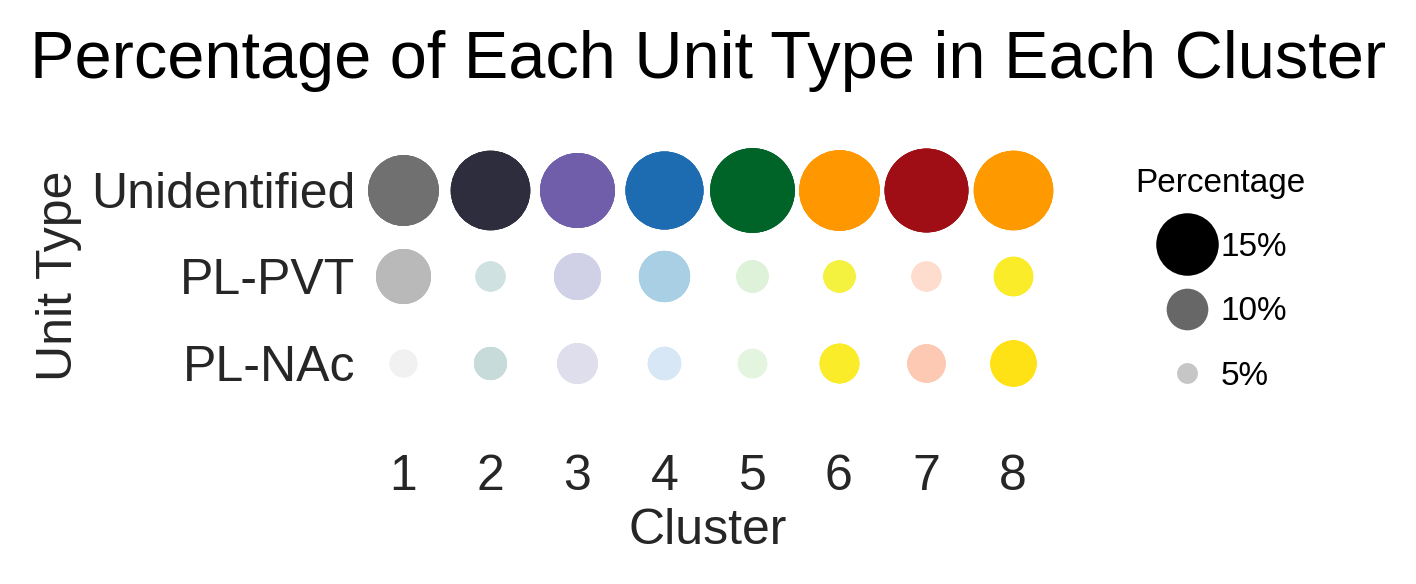

In [222]:


# Create a dictionary that maps each unit type to a unique numerical value
unit_type_dict = {unit_type: i for i, unit_type in enumerate(list((cluster_unit_type_perc_nogaba.columns)))}

# Get the maximum value of the dictionary values to normalize colors
max_value = cluster_unit_type_perc_nogaba.values.max()

# List of colormaps to cycle through
cmaps = ['Greys', 'bone_r','Purples', 'Blues', 'Greens', 'Wistia', 'Reds','Wistia',]


# Create a cycle object to cycle through the colormaps
cycle_cmaps = itertools.cycle(cmaps)

fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)

for cluster in cluster_unit_type_perc_nogaba.index.unique():
    # Get the current colormap
    cmap = cm.get_cmap(next(cycle_cmaps))
    cmap = mcolors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.1, b=0.6), 
    cmap(np.linspace(0.05, 0.9, 100)))
    
    for i, unit_type in enumerate(cluster_unit_type_perc_nogaba.columns):
        
        # Get the value for the current cluster and unit type
        value = cluster_unit_type_perc_nogaba.loc[cluster, unit_type]
        
        # Get the normalized color value, adjusted to use a subset of the colormap
        color_value = (value / max_value)
        
        ax.scatter([cluster] * len(cluster_unit_type_perc_nogaba.loc[cluster]),
                   [unit_type_dict[unit_type]] * len(cluster_unit_type_perc_nogaba.loc[cluster]), 
                   s=cluster_unit_type_perc_nogaba.loc[cluster, unit_type] * 5, 
                   c=[cmap(color_value)], alpha = 1)

# Use the unit type dictionary to set the y-tick labels
ax.set_yticks(list(unit_type_dict.values()))
ax.set_yticklabels(list(unit_type_dict.keys()))



ax.tick_params(length=0)
ax.set_xticks(list(cluster_unit_type_perc_nogaba.index))
ax.set_xticklabels(list(cluster_unit_type_perc_nogaba.index))
ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Increase the limits of y axis to avoid cutting off data
ax.set_xlim([min(cluster_unit_type_perc.index)-0.5, max(cluster_unit_type_perc.index)+0.5])
ax.set_ylim([min(unit_type_dict.values())-1, max(unit_type_dict.values())+1])



# Define the sizes you want to display in the legend
sizes = [5, 10, 15]

# Calculate the corresponding values for each size (assuming size is proportional to the value)
# Adjust the calculation according to your data and how you scale the sizes in the scatter plot
values = [s* 5 for s in sizes]

# Create legend elements
lengend_cmap = cm.get_cmap('Greys')
legend_elements = [Line2D([0], [0], marker='o', ls='',markeredgecolor = 'none',
                          markerfacecolor=lengend_cmap(v/max_value), markersize=s) 
                   for v, s in zip(values, sizes)]

# Create corresponding labels
labels = [f'{v}%' for v in sizes]  # or adjust as needed

# Create the legend
ax.legend(handles=reversed(legend_elements), labels=reversed(labels), title='Percentage',
          labelspacing=1, title_fontsize=8, fontsize = 8,
          handletextpad=0, frameon=False,  loc='upper right',  bbox_to_anchor=(1.4, 0.9))

plt.show()



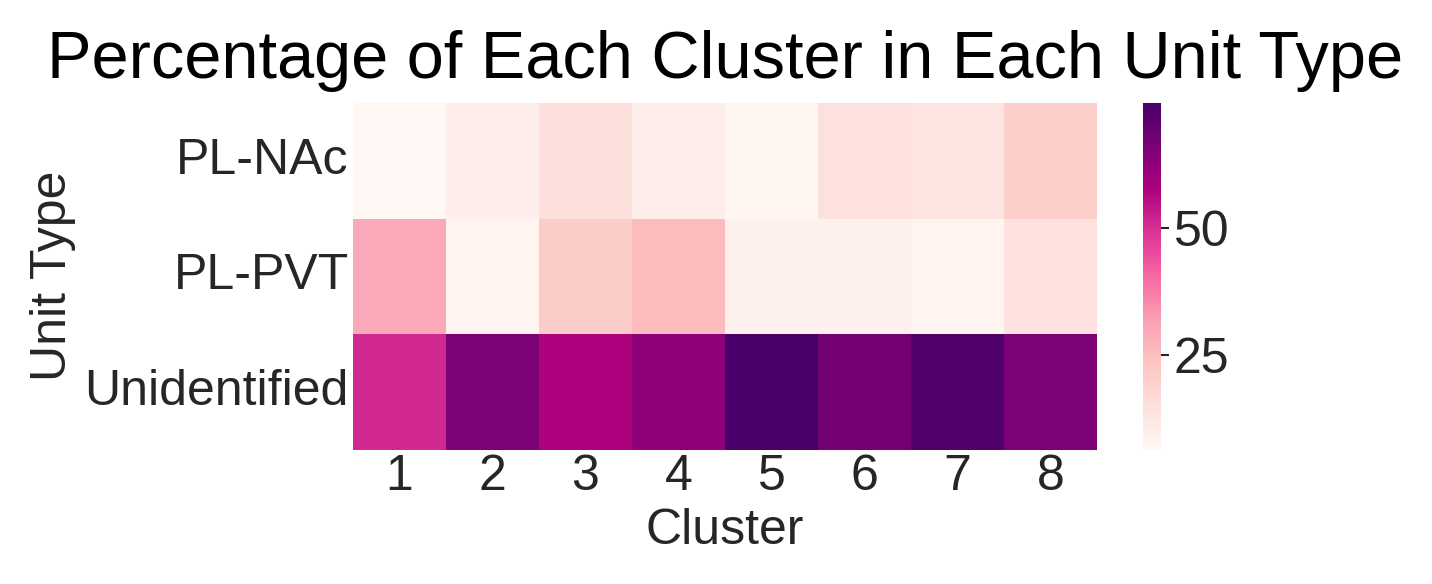

In [223]:
# Plot the percentage of each cluster in each unit type using a heatmap
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=300)
sns.heatmap(cluster_unit_type_perc_nogaba.T, ax=ax, cmap='RdPu')
ax.tick_params(length=0)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Cluster in Each Unit Type')

plt.show()

In [224]:
cluster_unit_type_perc

Unit_Type    PL GABA     PL-NAc     PL-PVT  Unidentified
Cluster                                                 
1          12.765957   6.382979  29.787234     51.063830
2          17.307692   9.615385   7.692308     65.384615
3           5.769231  15.384615  21.153846     57.692308
4           1.960784   9.803922  25.490196     62.745098
5           9.090909   7.272727   9.090909     74.545455
6           9.090909  14.545455   9.090909     67.272727
7           5.769231  13.461538   7.692308     73.076923
8           0.000000  20.408163  14.285714     65.306122

In [225]:
unit_type_cluster_counts

Cluster        1   2   3   4   5   6   7   8
Unit_Type                                   
PL GABA        6   9   3   1   5   5   3   0
PL-NAc         3   5   8   5   4   8   7  10
PL-PVT        14   4  11  13   5   5   4   7
Unidentified  24  34  30  32  41  37  38  32

In [226]:
unit_type_cluster_counts

Cluster        1   2   3   4   5   6   7   8
Unit_Type                                   
PL GABA        6   9   3   1   5   5   3   0
PL-NAc         3   5   8   5   4   8   7  10
PL-PVT        14   4  11  13   5   5   4   7
Unidentified  24  34  30  32  41  37  38  32

/tmp/ipykernel_3562044/602859745.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]
/tmp/ipykernel_3562044/602859745.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [desaturate_color(cm.get_cmap("tab20")(i / 20.0), 0.7) for i in range(0,20)]


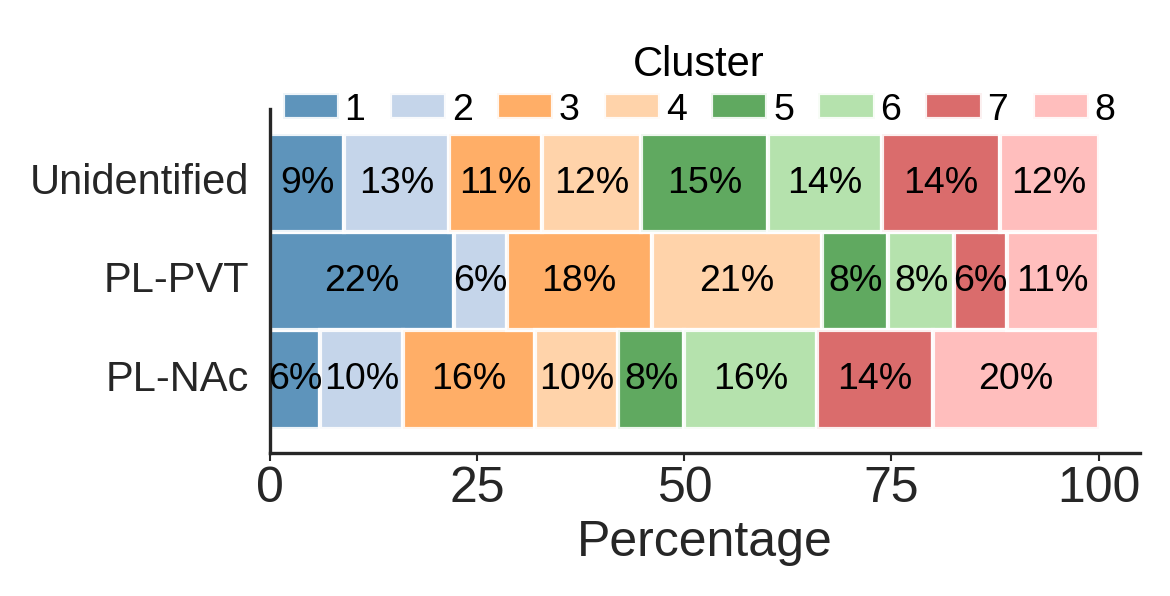

In [253]:
unit_type_cluster_perc_nogaba = unit_type_cluster_perc.iloc[unit_type_cluster_perc.index!='PL GABA']


# Convert unit_type_cluster_perc to percentage format
def distribute_remainder(row):
    # Find the integer parts and the decimal parts
    integer_parts = np.floor(row).astype(int)
    decimal_parts = row - integer_parts

    # Calculate how many points need to be distributed
    points_to_distribute = 100 - int(integer_parts.sum())

    # Get the indices in decreasing order of the decimal parts
    sorted_indices = np.argsort(decimal_parts)[::-1]

    # Distribute the points to the values with the largest decimal parts
    for i in range(points_to_distribute):
        index = sorted_indices.iloc[i]
        integer_parts.iloc[index] += 1

    # Convert to strings with '%' appended
    return integer_parts.astype(str) + '%'

perc_annot = unit_type_cluster_perc_nogaba.apply(distribute_remainder, axis=1)

# Get the middle color of each colormap
colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]
# Function to decrease the saturation of an RGB color
def desaturate_color(rgb_color, saturation_factor):
    # Convert RGB to HSV
    hsv_color = rgb_to_hsv(rgb_color[:3])  # Exclude the alpha value if present
    # Reduce the saturation component
    hsv_color[1] *= saturation_factor
    # Convert back to RGB and return with original alpha if it was included
    return hsv_to_rgb(hsv_color)


# Get the middle color of each colormap and desaturate
colors = [desaturate_color(cm.get_cmap("tab20")(i / 20.0), 0.7) for i in range(0,20)]

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
unit_type_cluster_perc_nogaba.plot(kind='barh', stacked=True, ax=ax, color=colors, align='center', width = 1, alpha = 0.9)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', pad=5, length=0)  # pad controls the distance
ax.set_yticklabels(unit_type_cluster_perc_nogaba.index, rotation=0, size = 10, va='center')
ax.set_xlabel('Percentage')
ax.set_ylabel(None)
# ax.set_title('Percentage of Each Cluster in Each Unit Type', y = 1.3 )

# Get the handles and labels of the current legend
handles, labels = ax.get_legend_handles_labels()

# For each bar, place a label
num_bars = len(unit_type_cluster_perc_nogaba.index)
for i in range(num_bars):
    # Get the size of each cluster in the bar
    sizes = unit_type_cluster_perc_nogaba.iloc[i].values
    x_position = 0  # starting x position of the text
    # For each cluster in the bar
    for j, size in enumerate(sizes):
        # x position is the x position of the bar plus half of its width
        x_position += size / 2
        # y position is the index of the bar
        y_position = i
        # Get the text from perc_annot
        text = perc_annot.iloc[i, j]
        # Check if text is not "0%", and then put it on the bar
        if text != "0%":
            ax.text(x_position, y_position, text, color = 'black', ha='center', va='center', fontsize=9)
        # Move x position to the end of this cluster for the next iteration
        x_position += size / 2

# Reverse the handles and labels
#handles = list(reversed(handles))
#labels = list(reversed(labels))

# Set the legend with the reversed handles and labels and without a box
ax.legend(handles, labels, mode = "expand", loc='upper center',  bbox_to_anchor=(0.22,0.2,0.75, 0.8), bbox_transform=plt.gcf().transFigure, 
          title="Cluster", title_fontsize=10, fontsize=9, ncol=len(labels), frameon=False, handlelength=1.5, handletextpad=0.15, columnspacing=1)

#plt.setp(ax.get_xticklabels(), position=(0, -0.05))

plt.tight_layout()
plt.savefig(f"/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_{behavior_str}_cluster_safe_vs_threat_percet.svg", transparent=False, bbox_inches='tight')

plt.show()

/tmp/ipykernel_3562044/1693699728.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]


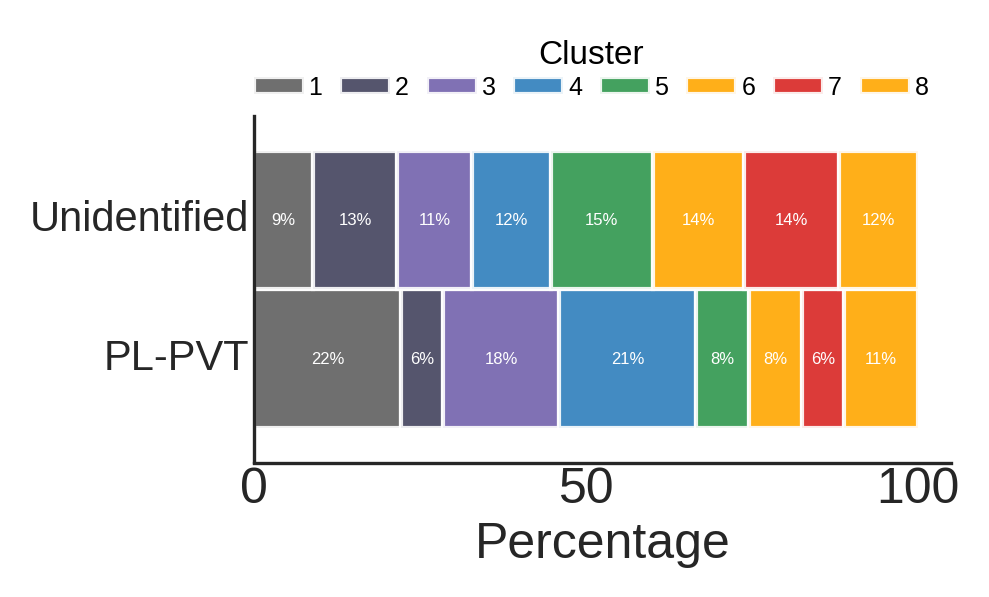

In [228]:
unit_type_cluster_perc_nogaba = unit_type_cluster_perc.loc[~unit_type_cluster_perc.index.isin(['PL GABA', 'PL-NAc'])]

# Convert unit_type_cluster_perc to percentage format
perc_annot = unit_type_cluster_perc_nogaba.apply(distribute_remainder, axis=1)



# Get the middle color of each colormap
colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)
unit_type_cluster_perc_nogaba.plot(kind='barh', stacked=True, ax=ax, color=colors, align='center', width = 1, alpha = 0.9)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.tick_params(length=0)

ax.set_yticklabels(unit_type_cluster_perc_nogaba.index, rotation=0, size = 10, va='center')
ax.set_xlabel('Percentage')
ax.set_ylabel(None)
# ax.set_title('Percentage of Each Cluster in Each Unit Type', y = 1.3 )

# Get the handles and labels of the current legend
handles, labels = ax.get_legend_handles_labels()

# For each bar, place a label
num_bars = len(unit_type_cluster_perc_nogaba.index)
for i in range(num_bars):
    # Get the size of each cluster in the bar
    sizes = unit_type_cluster_perc_nogaba.iloc[i].values
    x_position = 0  # starting x position of the text
    # For each cluster in the bar
    for j, size in enumerate(sizes):
        # x position is the x position of the bar plus half of its width
        x_position += size / 2
        # y position is the index of the bar
        y_position = i
        # Get the text from perc_annot
        text = perc_annot.iloc[i, j]
        # Check if text is not "0%", and then put it on the bar
        if text != "0%":
            ax.text(x_position, y_position, text, color = 'white', ha='center', va='center', fontsize=4)
        # Move x position to the end of this cluster for the next iteration
        x_position += size / 2

# Reverse the handles and labels
#handles = list(reversed(handles))
#labels = list(reversed(labels))

# Set the legend with the reversed handles and labels and without a box
ax.legend(handles, labels, mode = "expand", loc='upper center',  bbox_to_anchor=(0.1,0.3,0.8, 0.8), bbox_transform=plt.gcf().transFigure, 
          title="Cluster", title_fontsize=8, fontsize=6, ncol=len(labels), frameon=False, handlelength=2, handletextpad=0.2, columnspacing=1)

#plt.setp(ax.get_xticklabels(), position=(0, -0.05))
plt.show()

In [229]:
unit_type_cluster_perc_nogaba

Cluster               1          2          3          4          5  \
Unit_Type                                                             
PL-PVT        22.222222   6.349206  17.460317  20.634921   7.936508   
Unidentified   8.955224  12.686567  11.194030  11.940299  15.298507   

Cluster               6          7          8  
Unit_Type                                      
PL-PVT         7.936508   6.349206  11.111111  
Unidentified  13.805970  14.179104  11.940299

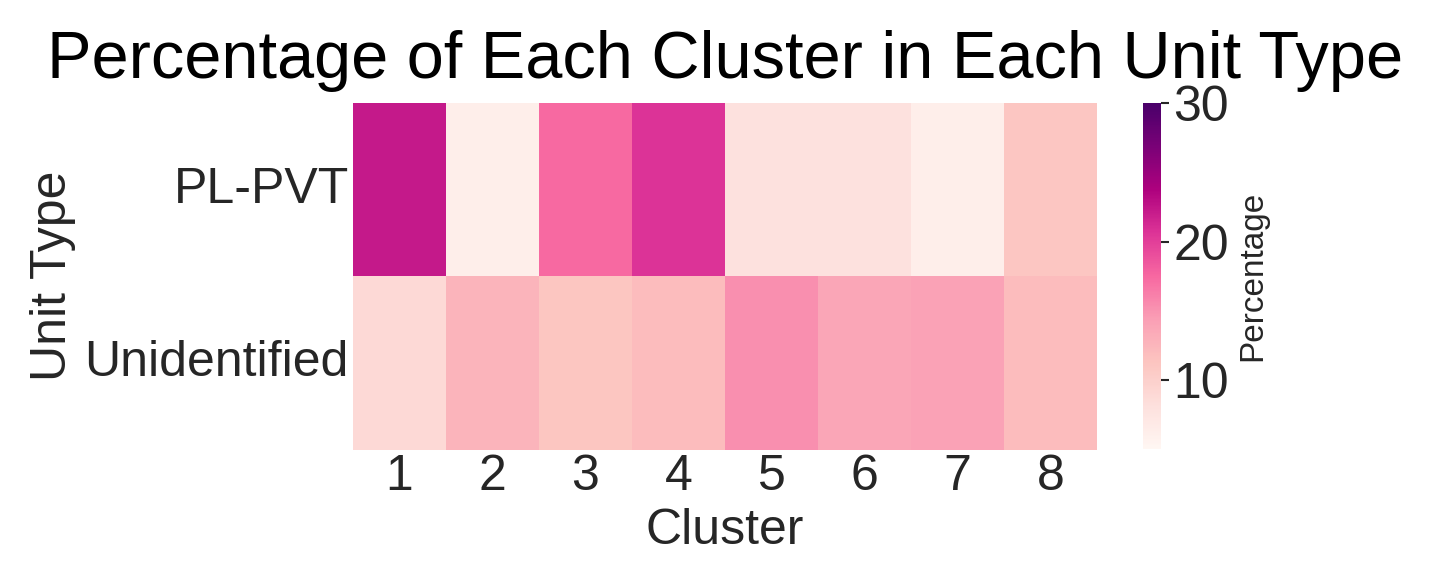

In [230]:
# Plot the percentage of each cluster in each unit type using a heatmap
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=300)
sns.heatmap(unit_type_cluster_perc_nogaba, ax=ax, cmap='RdPu', alpha = 1, cbar_kws={'label': 'Percentage'}, vmin=5, vmax=30)
ax.tick_params(length=0)
ax.figure.axes[-1].yaxis.label.set_size(8)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Cluster in Each Unit Type')

plt.show()

In [231]:
cluster_unit_type_perc

Unit_Type    PL GABA     PL-NAc     PL-PVT  Unidentified
Cluster                                                 
1          12.765957   6.382979  29.787234     51.063830
2          17.307692   9.615385   7.692308     65.384615
3           5.769231  15.384615  21.153846     57.692308
4           1.960784   9.803922  25.490196     62.745098
5           9.090909   7.272727   9.090909     74.545455
6           9.090909  14.545455   9.090909     67.272727
7           5.769231  13.461538   7.692308     73.076923
8           0.000000  20.408163  14.285714     65.306122

In [232]:
unit_type_cluster_counts

Cluster        1   2   3   4   5   6   7   8
Unit_Type                                   
PL GABA        6   9   3   1   5   5   3   0
PL-NAc         3   5   8   5   4   8   7  10
PL-PVT        14   4  11  13   5   5   4   7
Unidentified  24  34  30  32  41  37  38  32

In [233]:
unit_type_cluster_perc

Cluster               1          2          3          4          5  \
Unit_Type                                                             
PL GABA       18.750000  28.125000   9.375000   3.125000  15.625000   
PL-NAc         6.000000  10.000000  16.000000  10.000000   8.000000   
PL-PVT        22.222222   6.349206  17.460317  20.634921   7.936508   
Unidentified   8.955224  12.686567  11.194030  11.940299  15.298507   

Cluster               6          7          8  
Unit_Type                                      
PL GABA       15.625000   9.375000   0.000000  
PL-NAc        16.000000  14.000000  20.000000  
PL-PVT         7.936508   6.349206  11.111111  
Unidentified  13.805970  14.179104  11.940299

In [234]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(unit_type_cluster_perc.loc[["PL-NAc","PL-PVT", "Unidentified"]])

print(f"Chi-square statistic = {chi2}")
print(f"P-value = {p}")
print(f"Degrees of freedom = {dof}")
print("Expected:")
print(expected)

Chi-square statistic = 33.13917590648189
P-value = 0.0027507915211792606
Degrees of freedom = 14
Expected:
[[12.39248203  9.67859117 14.88478244 14.19173971 10.4116718  12.58082603
  11.50943694 14.35046987]
 [12.39248203  9.67859117 14.88478244 14.19173971 10.4116718  12.58082603
  11.50943694 14.35046987]
 [12.39248203  9.67859117 14.88478244 14.19173971 10.4116718  12.58082603
  11.50943694 14.35046987]]


In [235]:
# calculate standardized residuals
residuals = (unit_type_cluster_perc.loc[["PL-NAc","PL-PVT", "Unidentified"]] - expected) / np.sqrt(expected)

print("Standardized Residuals:")
print(residuals)

Standardized Residuals:
Cluster              1         2         3         4         5         6  \
Unit_Type                                                                  
PL-NAc       -1.815893  0.103312  0.289060 -1.112696 -0.747408  0.963977   
PL-PVT        2.792305 -1.070183  0.667569  1.710340 -0.767085 -1.309385   
Unidentified -0.976412  0.966870 -0.956629 -0.597644  1.514494  0.345408   

Cluster              7         8  
Unit_Type                         
PL-NAc        0.734126  1.491349  
PL-PVT       -1.521045 -0.855118  
Unidentified  0.786919 -0.636231  


In [236]:
# Number of rows and columns
r, c = unit_type_cluster_perc.loc[["PL-NAc", "PL-PVT", "Unidentified"]].shape

# Factor for adjusting the standardized residuals
adjustment_factor = np.sqrt(min(r - 1, c - 1))

# Calculate the adjusted residuals
adjusted_residuals = (unit_type_cluster_perc.loc[["PL-NAc", "PL-PVT", "Unidentified"]] - expected) / np.sqrt(expected) * adjustment_factor

print("Adjusted Residuals:")
print(adjusted_residuals)


Adjusted Residuals:
Cluster              1         2         3         4         5         6  \
Unit_Type                                                                  
PL-NAc       -2.568061  0.146106  0.408793 -1.573590 -1.056995  1.363269   
PL-PVT        3.948916 -1.513467  0.944085  2.418786 -1.084823 -1.851750   
Unidentified -1.380855  1.367361 -1.352878 -0.845197  2.141818  0.488481   

Cluster              7         8  
Unit_Type                         
PL-NAc        1.038211  2.109086  
PL-PVT       -2.151083 -1.209319  
Unidentified  1.112872 -0.899767  


In [237]:
unit_type_cluster_perc

Cluster               1          2          3          4          5  \
Unit_Type                                                             
PL GABA       18.750000  28.125000   9.375000   3.125000  15.625000   
PL-NAc         6.000000  10.000000  16.000000  10.000000   8.000000   
PL-PVT        22.222222   6.349206  17.460317  20.634921   7.936508   
Unidentified   8.955224  12.686567  11.194030  11.940299  15.298507   

Cluster               6          7          8  
Unit_Type                                      
PL GABA       15.625000   9.375000   0.000000  
PL-NAc        16.000000  14.000000  20.000000  
PL-PVT         7.936508   6.349206  11.111111  
Unidentified  13.805970  14.179104  11.940299

In [238]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(unit_type_cluster_perc.loc[["PL-NAc", "Unidentified"]])

print(f"Chi-square statistic = {chi2}")
print(f"P-value = {p}")
print(f"Degrees of freedom = {dof}")
print("Expected:")
print(expected)

Chi-square statistic = 6.405791256686149
P-value = 0.4932442784290393
Degrees of freedom = 7
Expected:
[[ 7.47761194 11.34328358 13.59701493 10.97014925 11.64925373 14.90298507
  14.08955224 15.97014925]
 [ 7.47761194 11.34328358 13.59701493 10.97014925 11.64925373 14.90298507
  14.08955224 15.97014925]]


In [239]:
from statsmodels.stats.proportion import proportions_ztest

# Assuming these are your counts for a specific cluster in two groups
count = np.array([unit_type_cluster_counts.loc['Unidentified', [4]].sum(), unit_type_cluster_counts.loc['PL-PVT', [4]].sum()])

# Assuming these are the number of observations in the two groups
nobs = np.array([unit_type_cluster_counts.loc['Unidentified', :].sum(), unit_type_cluster_counts.loc['PL-PVT', :].sum()])

# Perform the test
stat, pval = proportions_ztest(count, nobs)
print(f'z-statistic = {stat}')
print(f'p-value = {pval}')


z-statistic = -1.8118118978826467
p-value = 0.07001526607786582


In [240]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# Groups to compare
groups = ["PL-NAc", "PL-PVT", "Unidentified"]

# List to store comparison details
comparisons = []

# Loop through each cluster
for cls in uniquelabels + 1:  # assuming 7 clusters numbered 1 to 7
    
    # List to store raw p-values
    p_values = []
    
    # Loop through each pair of groups for comparison
    for group1, group2 in itertools.combinations(groups, 2):
        # counts for this specific cluster in two groups
        count = np.array([unit_type_cluster_counts.loc[group1, cls].sum(),
                          unit_type_cluster_counts.loc[group2, cls].sum()])
        
        # number of observations in the two groups
        nobs = np.array([unit_type_cluster_counts.loc[group1, :].sum(),
                         unit_type_cluster_counts.loc[group2, :].sum()])
        
        # perform the z-test
        stat, pval = proportions_ztest(count, nobs)
        
        # Append p-value
        p_values.append(pval)
    
    # Apply Holm-Sidak correction
    reject, corrected_p_values, _, _ = multipletests(p_values, method='holm-sidak')
    
    # Store the results
    for i, (group1, group2) in enumerate(itertools.combinations(groups, 2)):
        comparisons.append({'Cluster': cls, 'Group Comparison': f'{group1} vs. {group2}', 
                            'Raw p-value': p_values[i], 'Corrected p-value': corrected_p_values[i]})


# Create DataFrame from comparison details
results_df = pd.DataFrame(comparisons)

# Display the DataFrame
print(results_df)


    Cluster         Group Comparison  Raw p-value  Corrected p-value
0         1        PL-NAc vs. PL-PVT     0.016586           0.032896
1         1  PL-NAc vs. Unidentified     0.491314           0.491314
2         1  PL-PVT vs. Unidentified     0.002955           0.008840
3         2        PL-NAc vs. PL-PVT     0.476501           0.725949
4         2  PL-NAc vs. Unidentified     0.594966           0.725949
5         2  PL-PVT vs. Unidentified     0.155659           0.398059
6         3        PL-NAc vs. PL-PVT     0.836667           0.836667
7         3  PL-NAc vs. Unidentified     0.336160           0.559316
8         3  PL-PVT vs. Unidentified     0.174294           0.437041
9         4        PL-NAc vs. PL-PVT     0.124938           0.234267
10        4  PL-NAc vs. Unidentified     0.694461           0.694461
11        4  PL-PVT vs. Unidentified     0.070015           0.195683
12        5        PL-NAc vs. PL-PVT     0.990121           0.990121
13        5  PL-NAc vs. Unidentifi

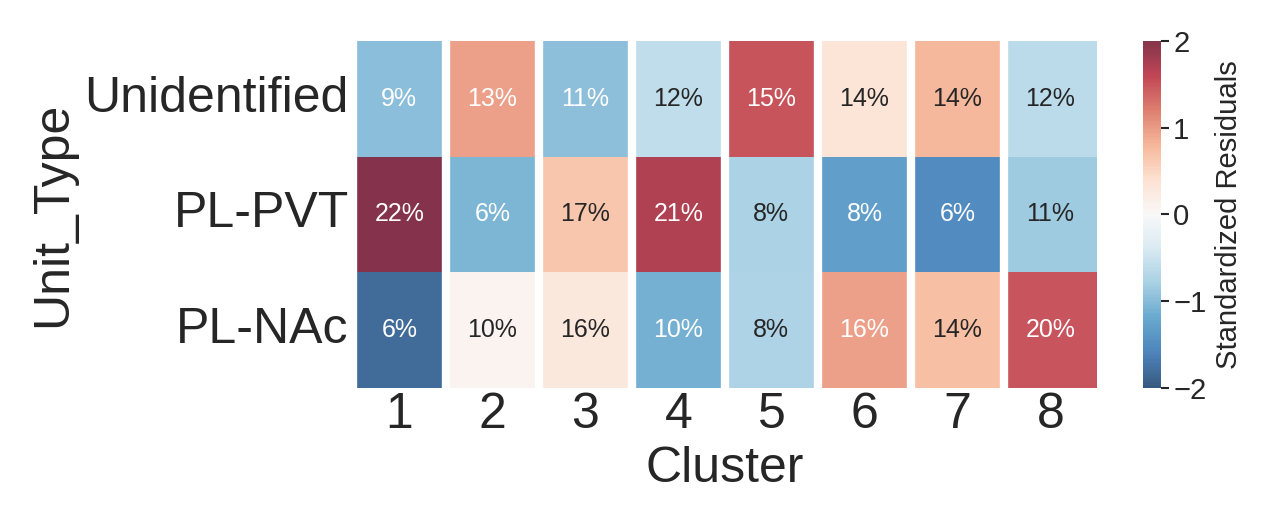

In [241]:

fig, ax = plt.subplots(figsize=(4, 1.5), dpi=300)

# Ensuring that unit_type_cluster_perc has the same shape as residuals
assert residuals.shape == unit_type_cluster_perc.loc[["PL-NAc","PL-PVT", "Unidentified"]].shape, "Data shape mismatch!"

# Convert unit_type_cluster_perc to percentage format
perc_annot = unit_type_cluster_perc.loc[["PL-NAc","PL-PVT", "Unidentified"]].round(0).astype(int).astype(str) + '%'

ax = sns.heatmap(residuals, annot=perc_annot, fmt='', cmap='RdBu_r', alpha = 0.8, 
                 cbar_kws={'label': 'Standardized Residuals'}, vmin=-2, vmax=2, annot_kws={"fontsize":6})

ax.figure.axes[-1].yaxis.label.set_size(7)
ax.figure.axes[-1].yaxis.set_tick_params(labelsize = 7)
ax.tick_params(length=0)

# Add white lines between each column to simulate gaps
for i in range(cluster):
    ax.axvline(i, color='white', lw=2)
    
# Reverse the order of the y-axis
ax.invert_yaxis()

plt.show()



/tmp/ipykernel_3562044/2902924317.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


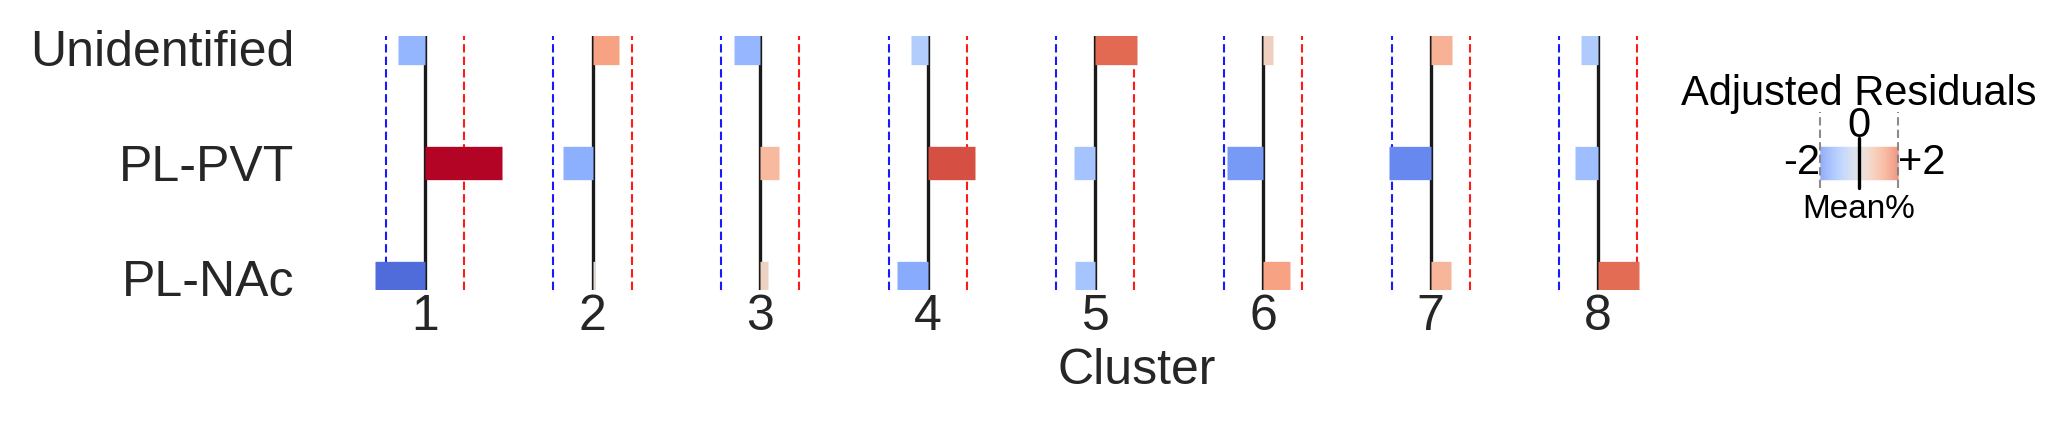

In [255]:
import matplotlib.cm as cm

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 1.5), dpi=300)

# Scaling factor
scaling_factor = 0.21

# Number of clusters
num_clusters = residuals.shape[1]

# Number of unit types
num_unit_types = residuals.shape[0]

# Spacing between clusters
cluster_spacing = 1.8

# Use the 'bwr' colormap
cmap = cm.get_cmap('coolwarm')

# Normalize the residuals to range [-3, 3]
norm = plt.Normalize(-3, 3)

# Loop through clusters
for j in range(num_clusters):
    # Calculate position taking into account the spacing between clusters
    position = j * cluster_spacing
    
    # Add a vertical line indicating zero for each cluster
    ax.axvline(x=position, color='black', linewidth=0.8, linestyle='-', alpha=0.9)
    # Add vertical dashed lines at -2 and 2 for each cluster
    ax.axvline(x=position - 2 * scaling_factor, color='blue', linewidth=0.5, linestyle='--', alpha=0.9)
    ax.axvline(x=position + 2 * scaling_factor, color='red', linewidth=0.5, linestyle='--', alpha=0.9)
    
    # Loop through unit types
    for i in range(num_unit_types):
        # Extract the residual
        residual = adjusted_residuals.iloc[i, j]
        # Scale the residual
        scaled_residual = residual * scaling_factor
        # Determine color from colormap
        color = cmap(norm(residual))
        # Plot horizontal line originating from the vertical line
        ax.hlines(y=i, xmin=position, xmax=position + scaled_residual, color=color, linewidth=8)

# Set y ticks to unit type names
ax.set_yticks(range(num_unit_types))
ax.set_yticklabels(residuals.index)

# Set x ticks to cluster names
x_positions = [j * cluster_spacing for j in range(num_clusters)]
ax.set_xticks(x_positions)
ax.set_xticklabels(residuals.columns)

# Label the axes
ax.set_xlabel("Cluster")
ax.set_ylabel(None)

# Create a custom scale bar in the same axis as the main plot
shift = 1
scale_bar_position = num_clusters * cluster_spacing + shift

# Create a gradient of colors for the scale bar
gradient = np.linspace(-2, 2, 256)
gradient_cmap = cmap(norm(gradient))

# Plot the scale bar segments with gradient colors
step = 4 / len(gradient)
for i in range(len(gradient) - 1):
    x_start = scale_bar_position - 2 * scaling_factor + i * step * scaling_factor
    x_end = scale_bar_position - 2 * scaling_factor + (i + 1) * step * scaling_factor
    ax.hlines(y=1, xmin=x_start, xmax=x_end, color=gradient_cmap[i], linewidth=8)

# Plot the dashed lines for the scale bar at -2 and 2
ax.axvline(x=scale_bar_position - 2 * scaling_factor, ymin = 0.4, ymax = 0.7, color='grey', linewidth=0.5, linestyle='--', alpha=0.9)
ax.axvline(x=scale_bar_position + 2 * scaling_factor, ymin = 0.4, ymax = 0.7, color='grey', linewidth=0.5, linestyle='--', alpha=0.9)

ax.axvline(x=scale_bar_position, ymin = 0.4, ymax = 0.6,color='black', linewidth=0.8, linestyle='-')

# Adding text to scale bar
ax.text(scale_bar_position + 2 * scaling_factor, 1, '+2', va='center', ha='left', fontsize=10)
ax.text(scale_bar_position - 2 * scaling_factor, 1, '-2', va='center', ha='right', fontsize=10)
ax.text(scale_bar_position, 1.32, '0', va='center', ha='center', fontsize=10)
ax.text(scale_bar_position, 0.6, 'Mean%', va='center', ha='center', fontsize=8)
ax.text(scale_bar_position, 1.6, 'Adjusted Residuals', va='center', ha='center', fontsize=10)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(length=0)

# Adjust layout and show plot
plt.tight_layout()

plt.savefig(f"/scratch/09117/xz6783/Xu/Plots/Fig5/fig5_{behavior_str}_cluster_safe_vs_threat_residual.svg", transparent=True, bbox_inches='tight')

plt.show()


/tmp/ipykernel_3978172/202678704.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')


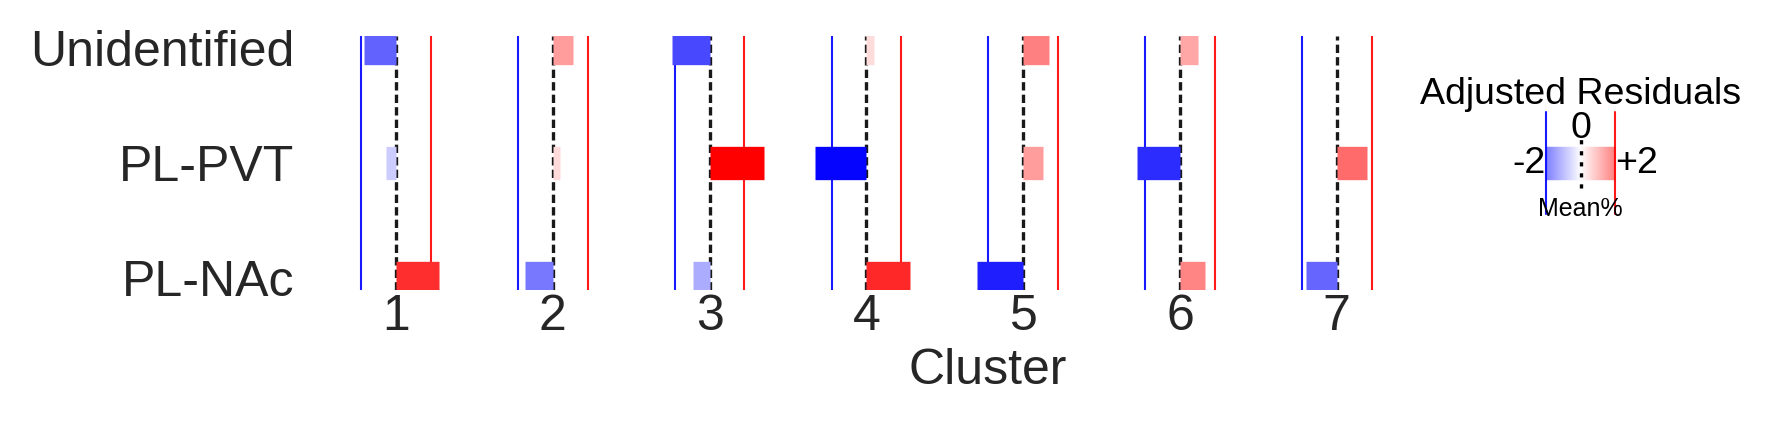

In [98]:
import matplotlib.cm as cm

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1.5), dpi=300)

# Scaling factor
scaling_factor = 0.2

# Number of clusters
num_clusters = residuals.shape[1]

# Number of unit types
num_unit_types = residuals.shape[0]

# Spacing between clusters
cluster_spacing = 1.8

# Use the 'bwr' colormap
cmap = cm.get_cmap('bwr')

# Normalize the residuals to range [-3, 3]
norm = plt.Normalize(-3, 3)

# Loop through clusters
for j in range(num_clusters):
    # Calculate position taking into account the spacing between clusters
    position = j * cluster_spacing
    
    # Add a vertical line indicating zero for each cluster
    ax.axvline(x=position, color='black', linewidth=0.8, linestyle='--', alpha=0.9)
    # Add vertical dashed lines at -2 and 2 for each cluster
    ax.axvline(x=position - 2 * scaling_factor, color='blue', linewidth=0.5, linestyle='-', alpha=0.9)
    ax.axvline(x=position + 2 * scaling_factor, color='red', linewidth=0.5, linestyle='-', alpha=0.9)
    
    # Loop through unit types
    for i in range(num_unit_types):
        # Extract the residual
        residual = adjusted_residuals.iloc[i, j]
        # Scale the residual
        scaled_residual = residual * scaling_factor
        # Determine color from colormap
        color = cmap(norm(residual))
        # Plot horizontal line originating from the vertical line
        ax.hlines(y=i, xmin=position, xmax=position + scaled_residual, color=color, linewidth=8)

# Set y ticks to unit type names
ax.set_yticks(range(num_unit_types))
ax.set_yticklabels(residuals.index)

# Set x ticks to cluster names
x_positions = [j * cluster_spacing for j in range(num_clusters)]
ax.set_xticks(x_positions)
ax.set_xticklabels(residuals.columns)

# Label the axes
ax.set_xlabel("Cluster")
ax.set_ylabel(None)

# Create a custom scale bar in the same axis as the main plot
shift = 1
scale_bar_position = num_clusters * cluster_spacing + shift

# Create a gradient of colors for the scale bar
gradient = np.linspace(-2, 2, 256)
gradient_cmap = cmap(norm(gradient))

# Plot the scale bar segments with gradient colors
step = 4 / len(gradient)
for i in range(len(gradient) - 1):
    x_start = scale_bar_position - 2 * scaling_factor + i * step * scaling_factor
    x_end = scale_bar_position - 2 * scaling_factor + (i + 1) * step * scaling_factor
    ax.hlines(y=1, xmin=x_start, xmax=x_end, color=gradient_cmap[i], linewidth=8)

# Plot the dashed lines for the scale bar at -2 and 2
ax.axvline(x=scale_bar_position - 2 * scaling_factor, ymin = 0.3, ymax = 0.7, color='blue', linewidth=0.5, linestyle='-', alpha=0.9)
ax.axvline(x=scale_bar_position + 2 * scaling_factor, ymin = 0.3, ymax = 0.7, color='red', linewidth=0.5, linestyle='-', alpha=0.9)

ax.axvline(x=scale_bar_position, ymin = 0.4, ymax = 0.6,color='black', linewidth=0.8, linestyle=':')

# Adding text to scale bar
ax.text(scale_bar_position + 2 * scaling_factor, 1, '+2', va='center', ha='left', fontsize=9)
ax.text(scale_bar_position - 2 * scaling_factor, 1, '-2', va='center', ha='right', fontsize=9)
ax.text(scale_bar_position, 1.3, '0', va='center', ha='center', fontsize=9)
ax.text(scale_bar_position, 0.6, 'Mean%', va='center', ha='center', fontsize=6)
ax.text(scale_bar_position, 1.6, 'Adjusted Residuals', va='center', ha='center', fontsize=9)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(length=0)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_275782/2610406033.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]
/tmp/ipykernel_275782/2610406033.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')


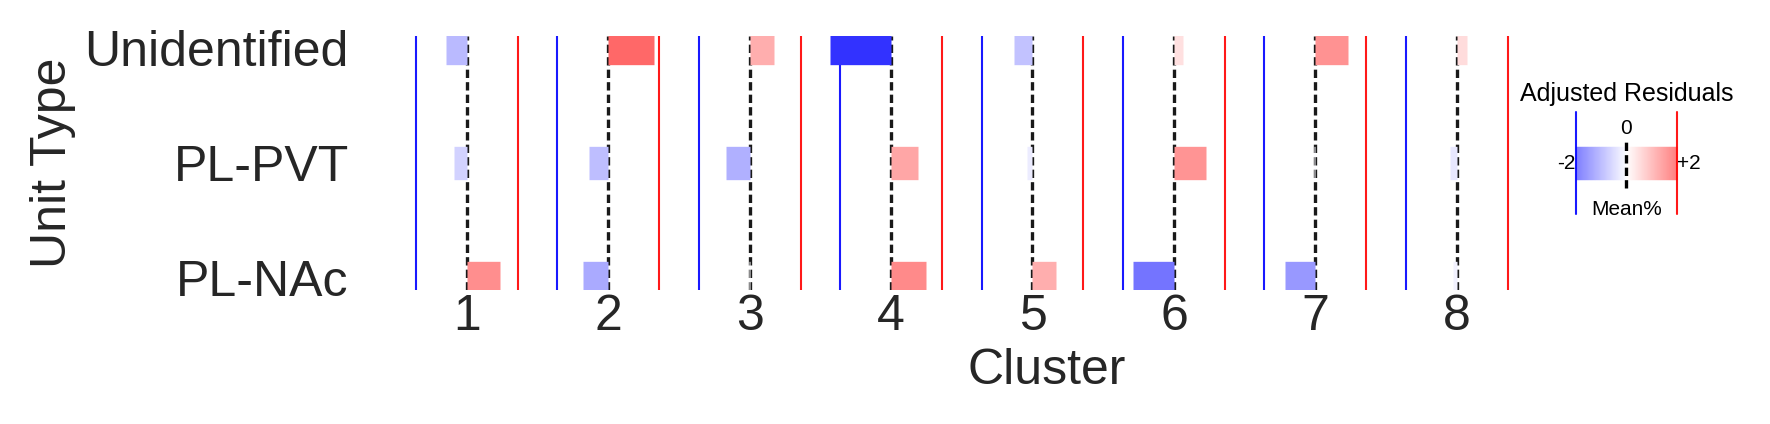

In [233]:
import matplotlib.cm as cm

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1.5), dpi=300)

# Scaling factor
scaling_factor = 0.18

# Number of clusters
num_clusters = residuals.shape[1]

# Number of unit types
num_unit_types = residuals.shape[0]

# Spacing between clusters
cluster_spacing = 1.5

# Get the middle color of each colormap
colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]

# Use the 'RdBu_r' colormap
cmap = cm.get_cmap('bwr')

# Normalize the residuals to range [0,1]
#norm = plt.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
norm = plt.Normalize(-3, 3)

# Loop through clusters
for j in range(num_clusters):
    # Add a vertical line indicating zero for each cluster
    ax.axvline(x=j, color='black', linewidth=0.8, linestyle='--', alpha = 0.9)
    # Add vertical dashed lines at -2 and 2 for each cluster
    ax.axvline(x=j - 2 * scaling_factor, color='blue', linewidth=0.5, linestyle='-', alpha=0.9)
    ax.axvline(x=j + 2 * scaling_factor, color='red', linewidth=0.5, linestyle='-', alpha=0.9)
    
    # Loop through unit types
    for i in range(num_unit_types):
        # Extract the residual
        residual = adjusted_residuals.iloc[i, j]
        # Scale the residual
        scaled_residual = residual * scaling_factor
        # Determine color from colormap
        color = cmap(norm(residual))
        # Plot horizontal line originating from the vertical line
        ax.hlines(y=i, xmin=j, xmax=j + scaled_residual, color=color, linewidth=8)

# Set y ticks to unit type names
ax.set_yticks(range(num_unit_types))
ax.set_yticklabels(residuals.index)

# Set x ticks to cluster names
ax.set_xticks(range(num_clusters))
ax.set_xticklabels(residuals.columns)

# Label the axes
ax.set_xlabel("Cluster")
ax.set_ylabel("Unit Type")



# Create a custom scale bar in the same axis as the main plot
shift = 0.2
#ax.hlines(y=1, xmin=shift+num_clusters - 2 * scaling_factor, xmax=shift+num_clusters, color=cmap(norm(-2)), linewidth=8)
#ax.hlines(y=1, xmin= shift+num_clusters, xmax = shift+num_clusters + 2 * scaling_factor, color=cmap(norm(2)), linewidth=8)
#ax.hlines(y=1, xmin= shift+num_clusters - 2 * scaling_factor, xmax = shift+num_clusters + 2 * scaling_factor, color=gradient_cmap, linewidth=8)

# Create a gradient of colors for the scale bar
gradient = np.linspace(-2, 2, 256)
gradient_cmap = cmap(norm(gradient))

# Plot the scale bar segments with gradient colors
step = 4/len(gradient)
for i in range(len(gradient)-1):
    x_start = shift + num_clusters - 2 * scaling_factor + i * step*scaling_factor
    x_end = shift + num_clusters - 2 * scaling_factor + (i+1) * step*scaling_factor
    ax.hlines(y=1, xmin=x_start, xmax=x_end, color=gradient_cmap[i], linewidth=8)
    
ax.axvline(x=shift + num_clusters - 2 * scaling_factor, ymin = 0.3, ymax = 0.7, color='blue', linewidth=0.5, linestyle='-', alpha=0.9)
ax.axvline(x=shift + num_clusters + 2 * scaling_factor, ymin = 0.3, ymax = 0.7, color='red', linewidth=0.5, linestyle='-', alpha=0.9)

ax.axvline(x=shift+num_clusters, ymin = 0.4, ymax = 0.6,color='black', linewidth=0.8, linestyle='--')
ax.text(shift+num_clusters + 2 * scaling_factor, 1, '+2', va='center', ha='left', fontsize=5)
ax.text(shift+num_clusters - 2 * scaling_factor, 1, '-2', va='center', ha='right', fontsize=5)
ax.text(shift+num_clusters, 1.3 , '0', va='center', ha='center', fontsize=5)
ax.text(shift+num_clusters , 0.6, 'Mean%', va='center', ha='center', fontsize=5)
ax.text(shift+num_clusters , 1.6, 'Adjusted Residuals', va='center', ha='center', fontsize=6)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(length=0)


# Adjust layout and show plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_659857/1999276590.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]


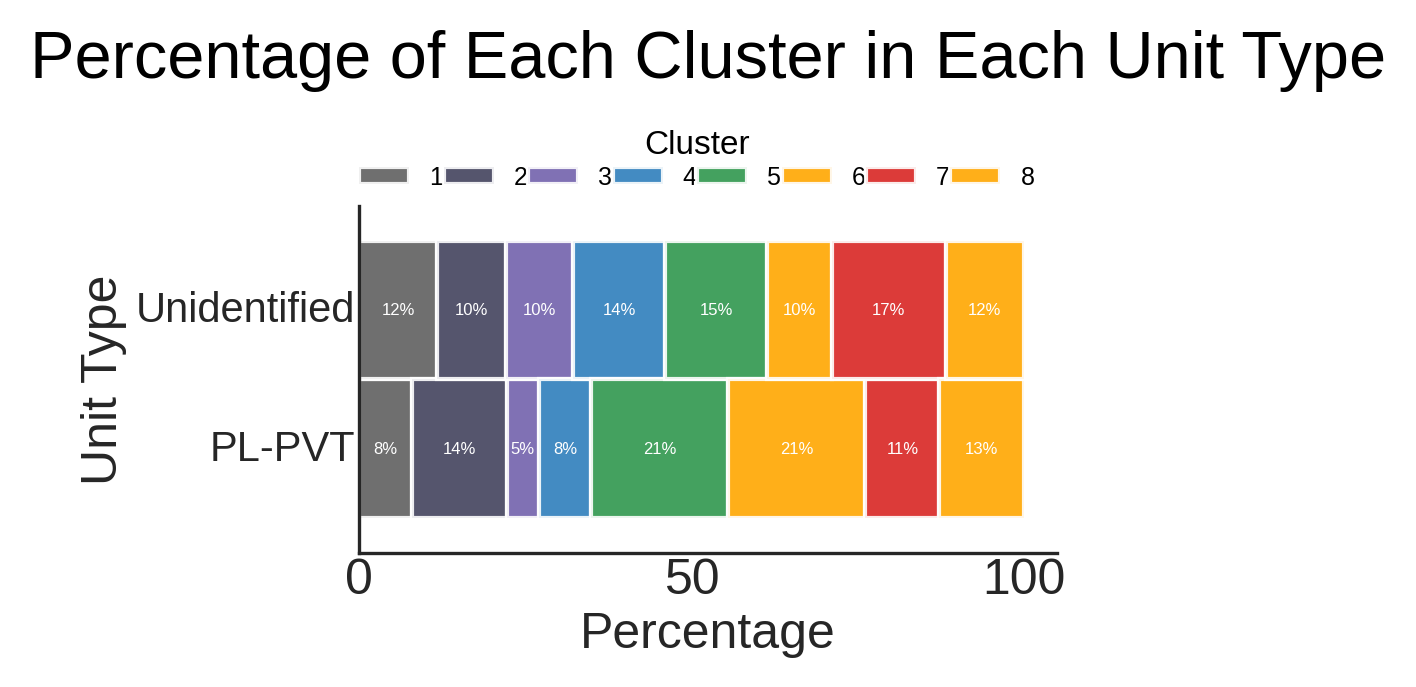

In [75]:
unit_type_cluster_perc_nogaba = unit_type_cluster_perc.loc[~unit_type_cluster_perc.index.isin(['PL GABA', 'PL-NAc'])]

# Convert unit_type_cluster_perc to percentage format
perc_annot = unit_type_cluster_perc_nogaba.round(0).astype(int).astype(str) + '%'


# Get the middle color of each colormap
colors = [cm.get_cmap(cmap)(0.7) for cmap in cmaps]

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)
unit_type_cluster_perc_nogaba.plot(kind='barh', stacked=True, ax=ax, color=colors, align='center', width = 1, alpha = 0.9)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.tick_params(length=0)

ax.set_yticklabels(unit_type_cluster_perc_nogaba.index, rotation=0, size = 10, va='center')
ax.set_xlabel('Percentage')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Cluster in Each Unit Type', y = 1.3 )

# Get the handles and labels of the current legend
handles, labels = ax.get_legend_handles_labels()

# For each bar, place a label
num_bars = len(unit_type_cluster_perc_nogaba.index)
for i in range(num_bars):
    # Get the size of each cluster in the bar
    sizes = unit_type_cluster_perc_nogaba.iloc[i].values
    x_position = 0  # starting x position of the text
    # For each cluster in the bar
    for j, size in enumerate(sizes):
        # x position is the x position of the bar plus half of its width
        x_position += size / 2
        # y position is the index of the bar
        y_position = i
        # Get the text from perc_annot
        text = perc_annot.iloc[i, j]
        # Check if text is not "0%", and then put it on the bar
        if text != "0%":
            ax.text(x_position, y_position, text, color = 'white', ha='center', va='center', fontsize=4)
        # Move x position to the end of this cluster for the next iteration
        x_position += size / 2

# Reverse the handles and labels
#handles = list(reversed(handles))
#labels = list(reversed(labels))

# Set the legend with the reversed handles and labels and without a box
ax.legend(handles, labels, mode = "expand", loc='upper center',  bbox_to_anchor=(0.1,0.3,0.8, 0.8), bbox_transform=plt.gcf().transFigure, 
          title="Cluster", title_fontsize=8, fontsize=6, ncol=len(labels), frameon=False)

#plt.setp(ax.get_xticklabels(), position=(0, -0.05))
plt.show()

In [76]:
unit_type_cluster_perc_nogaba

Cluster               1          2          3          4          5  \
Unit_Type                                                             
PL-PVT         7.936508  14.285714   4.761905   7.936508  20.634921   
Unidentified  11.744966  10.402685  10.067114  13.758389  15.436242   

Cluster               6          7          8  
Unit_Type                                      
PL-PVT        20.634921  11.111111  12.698413  
Unidentified   9.731544  17.114094  11.744966

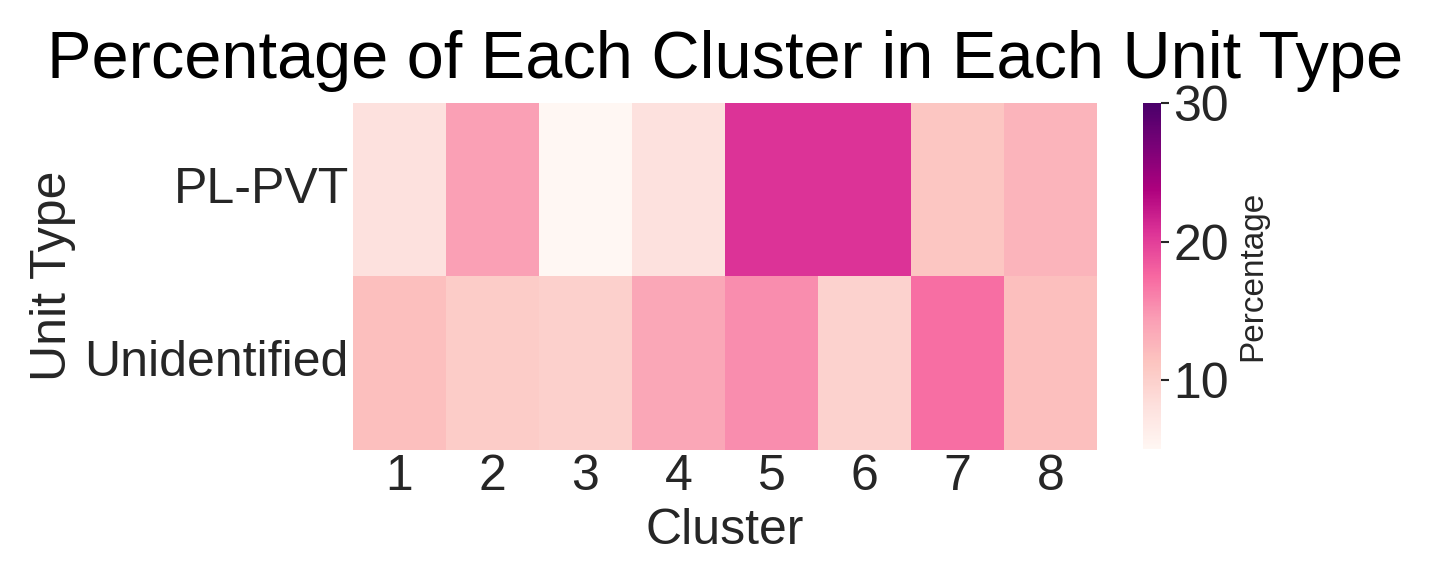

In [77]:
# Plot the percentage of each cluster in each unit type using a heatmap
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=300)
sns.heatmap(unit_type_cluster_perc_nogaba, ax=ax, cmap='RdPu', alpha = 1, cbar_kws={'label': 'Percentage'}, vmin=5, vmax=30)
ax.tick_params(length=0)
ax.figure.axes[-1].yaxis.label.set_size(8)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Cluster in Each Unit Type')

plt.show()

In [78]:
cluster_unit_type_perc

Unit_Type     PL-NAc     PL-PVT  Unidentified
Cluster                                      
1          21.568627   9.803922     68.627451
2          13.043478  19.565217     67.391304
3          10.810811   8.108108     81.081081
4          13.207547   9.433962     77.358491
5           9.230769  20.000000     70.769231
6          14.285714  26.530612     59.183673
7           7.936508  11.111111     80.952381
8          10.416667  16.666667     72.916667

In [79]:
unit_type_cluster_counts

Cluster        1   2   3   4   5   6   7   8
Unit_Type                                   
PL-NAc        11   6   4   7   6   7   5   5
PL-PVT         5   9   3   5  13  13   7   8
Unidentified  35  31  30  41  46  29  51  35

In [80]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(unit_type_cluster_perc.loc[["PL-PVT", "Unidentified"]])

print(f"Chi-square statistic = {chi2}")
print(f"P-value = {p}")
print(f"Degrees of freedom = {dof}")
print("Expected:")
print(expected)


Chi-square statistic = 10.786112528636949
P-value = 0.14822462159872096
Degrees of freedom = 7
Expected:
[[ 9.84073719 12.34419942  7.41450943 10.8474486  18.03558112 15.18323213
  14.11260254 12.22168957]
 [ 9.84073719 12.34419942  7.41450943 10.8474486  18.03558112 15.18323213
  14.11260254 12.22168957]]


In [81]:
# calculate standardized residuals
residuals = (unit_type_cluster_perc.loc[["PL-PVT", "Unidentified"]] - expected) / np.sqrt(expected)

print("Standardized Residuals:")
print(residuals)

Standardized Residuals:
Cluster              1         2         3         4         5         6  \
Unit_Type                                                                  
PL-PVT       -0.607023  0.552598 -0.974162 -0.883832  0.612066  1.399101   
Unidentified  0.607023 -0.552598  0.974162  0.883832 -0.612066 -1.399101   

Cluster              7         8  
Unit_Type                         
PL-PVT       -0.798976  0.136364  
Unidentified  0.798976 -0.136364  
